In [ ]:
# Standard library
import os
import ast
import random
from pathlib import Path

# Core scientific stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image, ImageOps
from tqdm import tqdm

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.data import AUTOTUNE as tf_AUTOTUNE

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    r2_score,
)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset root directory
DATA_ROOT = Path("/content/drive/MyDrive/2025_Dataset")
print("Root exists:", DATA_ROOT.exists())

def parse_pose_folder_name(folder_name: str):
    # Convert folde into pitch and roll values
    p_part, r_part = folder_name.split("_R")
    pitch = int(p_part[1:])   # remove 'P'
    roll = int(r_part)
    return pitch, roll

# Collect metadata for all images
all_rows = []

for pose_dir in sorted(DATA_ROOT.iterdir()):
    if not pose_dir.is_dir():
        continue

    folder_name = pose_dir.name
    if not folder_name.startswith("P"):
        continue  # skip non pose folders

    pitch, roll = parse_pose_folder_name(folder_name)
    depth_file = pose_dir / f"{folder_name}_depth.txt"

    if not depth_file.exists():
        print("Missing depth file for", folder_name)
        continue

    with open(depth_file) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Each line stores (image_filename, depth_value)
            fname, depth = ast.literal_eval(line)

            image_path = pose_dir / fname
            all_rows.append({
                "image_name": fname,
                "image_path": image_path,
                "depth": float(depth),
                "pitch": pitch,
                "roll": roll,
            })

labels_df = pd.DataFrame(all_rows)
print("Total images:", len(labels_df))
labels_df.head()

Mounted at /content/drive
Root exists: True
Total images: 2000


image_name  \
0  video_14_stable_bot_l6s3_P0_R0_00219.jpg   
1  video_14_stable_bot_l6s3_P0_R0_00222.jpg   
2  video_14_stable_bot_l6s3_P0_R0_00228.jpg   
3  video_14_stable_bot_l6s3_P0_R0_00120.jpg   
4  video_14_stable_bot_l6s3_P0_R0_00198.jpg   

                                          image_path  depth  pitch  roll  
0  /content/drive/MyDrive/2025_Dataset/P0_R0/vide...  0.785      0     0  
1  /content/drive/MyDrive/2025_Dataset/P0_R0/vide...  0.686      0     0  
2  /content/drive/MyDrive/2025_Dataset/P0_R0/vide...  0.991      0     0  
3  /content/drive/MyDrive/2025_Dataset/P0_R0/vide...  0.103      0     0  
4  /content/drive/MyDrive/2025_Dataset/P0_R0/vide...  0.931      0     0

In [ ]:
# Original dataset root and output directory for fixed images
DATA_ROOT = Path("/content/drive/MyDrive/2025_Dataset")
FIXED_ROOT = Path("/content/drive/MyDrive/2025_Dataset_fixed")
FIXED_ROOT.mkdir(parents=True, exist_ok=True)

def fix_exif_and_save(src_path: Path) -> Path:
    # Preserve original folder structure under FIXED_ROOT
    rel = src_path.relative_to(DATA_ROOT)
    dst_path = FIXED_ROOT / rel
    dst_path.parent.mkdir(parents=True, exist_ok=True)

    # Skip processing if already fixed
    if dst_path.exists():
        return dst_path

    # Apply EXIF orientation correction and save
    with Image.open(src_path) as img:
        img_fixed = ImageOps.exif_transpose(img)
        img_fixed.save(dst_path)

    return dst_path

fixed_paths = []

print("Applying EXIF orientation and saving fixed copies (skipping existing)...")
for p in tqdm(labels_df["image_path"]):
    p = Path(p)
    fixed_paths.append(fix_exif_and_save(p))

# Update dataframe to point to fixed images
labels_df["image_path"] = fixed_paths
print("Example fixed path:", labels_df["image_path"].iloc[0])

Applying EXIF orientation and saving fixed copies (skipping existing)...


100%|██████████| 2000/2000 [00:21<00:00, 94.82it/s]

Example fixed path: /content/drive/MyDrive/2025_Dataset_fixed/P0_R0/video_14_stable_bot_l6s3_P0_R0_00219.jpg


In [ ]:
# Create a discrete class label for each (pitch, roll) pose
pose_tuples = sorted(set(zip(labels_df["pitch"], labels_df["roll"])))

# Map each unique pose to an integer class index
pose_to_idx = {pose: idx for idx, pose in enumerate(pose_tuples)}
idx_to_pose = {v: k for k, v in pose_to_idx.items()}

# Assign pose class to each sample
labels_df["pose_class"] = labels_df.apply(
    lambda r: pose_to_idx[(r["pitch"], r["roll"])],
    axis=1
)

print("Number of pose classes:", len(pose_to_idx))
print("Example pose mapping (first 5):")
for k in list(pose_to_idx.keys())[:5]:
    print(f"  pose {k} -> class {pose_to_idx[k]}")

Number of pose classes: 40
Example pose mapping (first 5):
  pose (0, 0) -> class 0
  pose (5, 0) -> class 1
  pose (10, 0) -> class 2
  pose (15, 0) -> class 3
  pose (15, 5) -> class 4


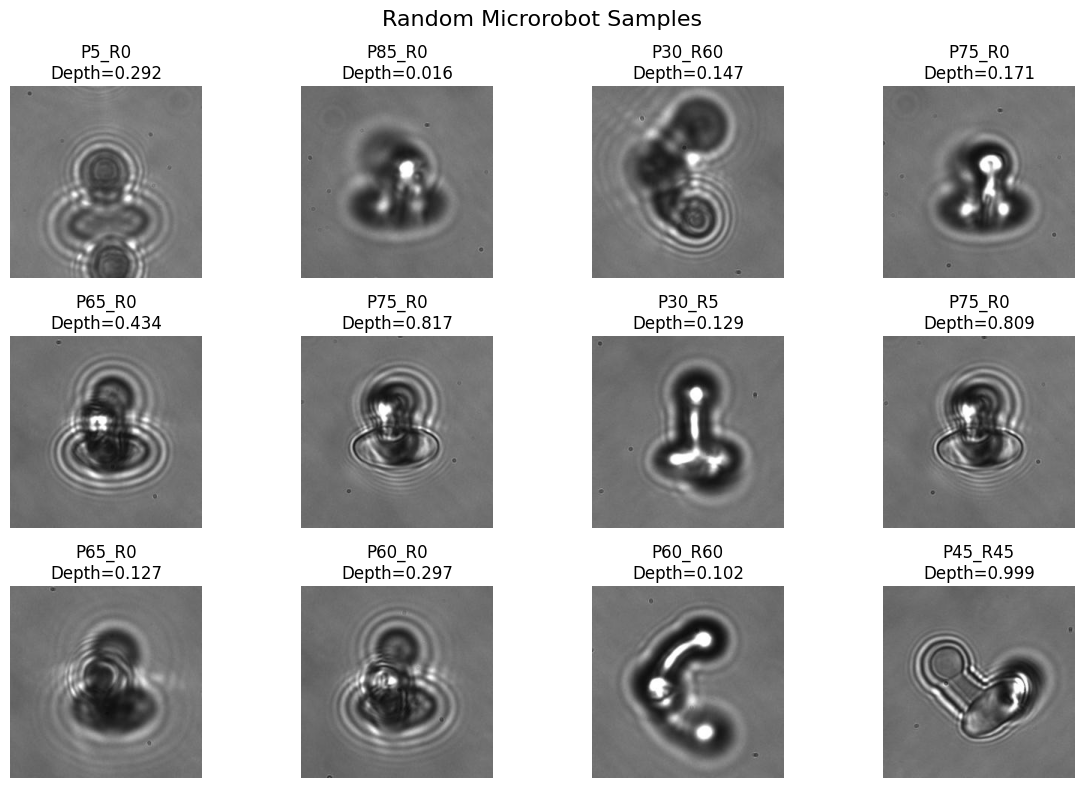

In [ ]:
# Random sample of images
num_samples = 12
sample_rows = labels_df.sample(num_samples)

plt.figure(figsize=(12, 8))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img = Image.open(row["image_path"]).convert("RGB")

    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"P{row['pitch']}_R{row['roll']}\nDepth={row['depth']:.3f}")
    plt.axis("off")

plt.suptitle("Random Microrobot Samples", fontsize=16)
plt.tight_layout()
plt.show()


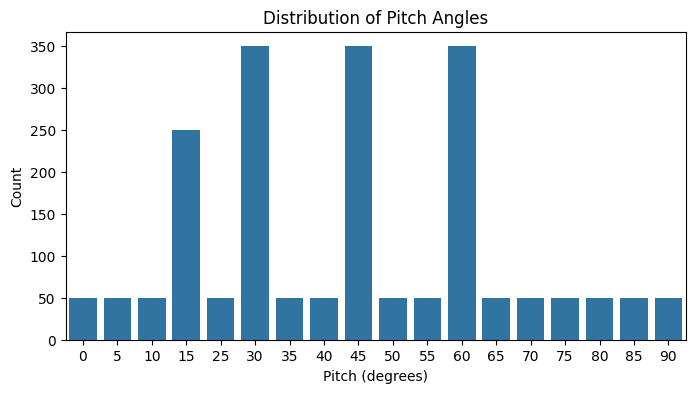

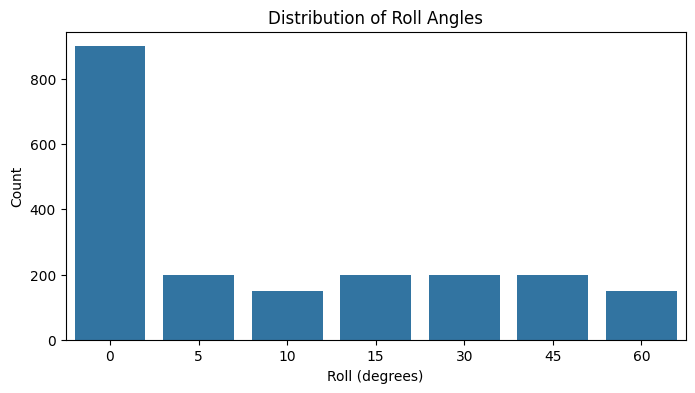

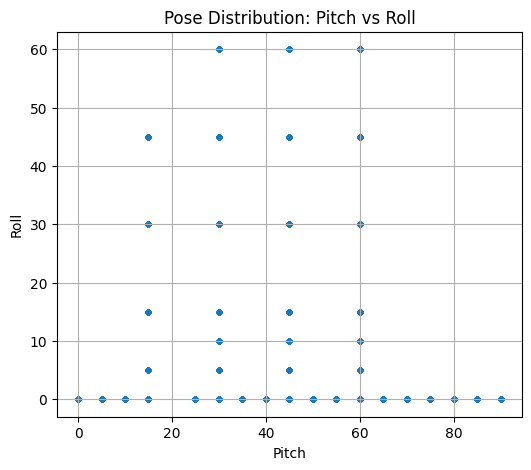

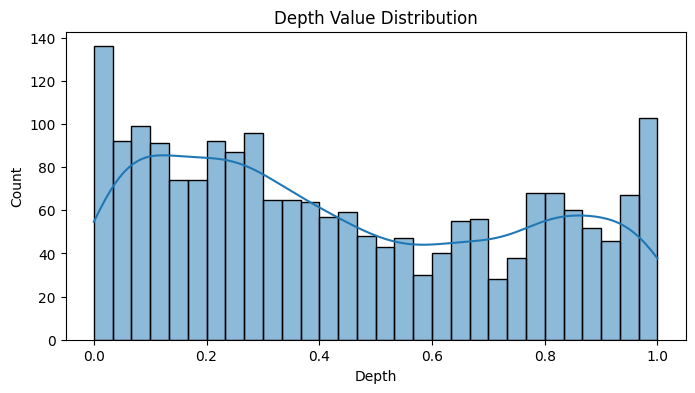

In [ ]:
# --- Pitch distribution ---
plt.figure(figsize=(8,4))
sns.countplot(x=labels_df["pitch"])
plt.title("Distribution of Pitch Angles")
plt.xlabel("Pitch (degrees)")
plt.ylabel("Count")
plt.show()

# --- Roll distribution ---
plt.figure(figsize=(8,4))
sns.countplot(x=labels_df["roll"])
plt.title("Distribution of Roll Angles")
plt.xlabel("Roll (degrees)")
plt.ylabel("Count")
plt.show()

# --- Pitch vs Roll scatter ---
plt.figure(figsize=(6,5))
plt.scatter(labels_df["pitch"], labels_df["roll"], alpha=0.3, s=10)
plt.title("Pose Distribution: Pitch vs Roll")
plt.xlabel("Pitch")
plt.ylabel("Roll")
plt.grid(True)
plt.show()

# --- Depth histogram ---
plt.figure(figsize=(8,4))
sns.histplot(labels_df["depth"], bins=30, kde=True)
plt.title("Depth Value Distribution")
plt.xlabel("Depth")
plt.ylabel("Count")
plt.show()


In [ ]:
# Data augmentation for training images


IMG_SIZE = 224

# Augmentations applied only during training
data_augmentation_layers = [
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.1),
]

def data_augmentation(images, training=True):
    if not training:
        return images

    for layer in data_augmentation_layers:
        images = layer(images)

    return images


Using image: /content/drive/MyDrive/2025_Dataset_fixed/P60_R10/video_14_stable_bot_l6s3_P60_R10_01522.jpg


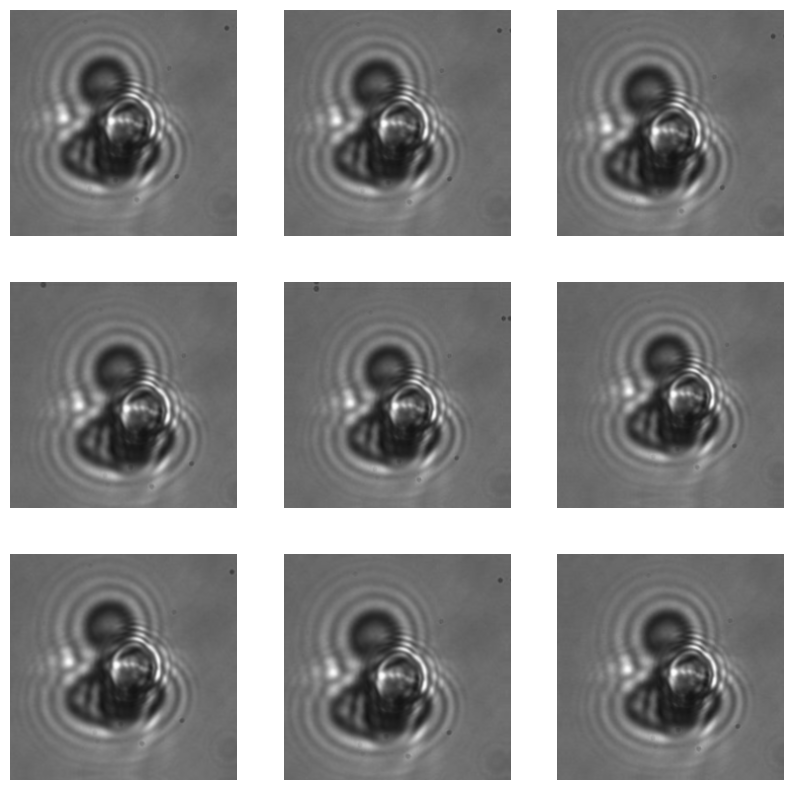

In [ ]:
# Pick a random image from the dataset
row = labels_df.sample(1).iloc[0]
img_path = str(row["image_path"])
print("Using image:", img_path)

# Load image and normalize to [0, 1]
img_raw = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img_raw, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img = img / 255.0

plt.figure(figsize=(10, 10))
for i in range(9):
    # Recreate augmentation layers to get different random results
    data_augmentation_layers = [
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomZoom(0.05),
    ]

    # Add batch dimension for Keras layers
    img_batch = tf.expand_dims(img, axis=0)

    augmented_img = img_batch
    for layer in data_augmentation_layers:
        augmented_img = layer(augmented_img)

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_img[0].numpy())
    plt.axis("off")

In [ ]:
# Normalization

# Pixel normalization
rescale = layers.Rescaling(1.0 / 255.0)

# Depth normalization
depth_mean = labels_df["depth"].mean()
depth_std = labels_df["depth"].std()

labels_df["depth_norm"] = (labels_df["depth"] - depth_mean) / depth_std

print("Depth mean:", depth_mean)
print("Depth std:", depth_std)


Depth mean: 0.44319800000000004
Depth std: 0.3121625674712861


In [ ]:
# Stratified split by pose class: 60% train, 20% val, 20% test
rng = np.random.default_rng(seed=1337)  # reproducibility

train_parts = []
val_parts = []
test_parts = []

for pose_cls, group in labels_df.groupby("pose_class"):
    # Shuffle samples within each pose class
    group = group.sample(frac=1.0, random_state=1337)

    n = len(group)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)

    train_parts.append(group.iloc[:n_train])
    val_parts.append(group.iloc[n_train:n_train + n_val])
    test_parts.append(group.iloc[n_train + n_val:])

# Merge and shuffle each split
train_df = pd.concat(train_parts).sample(frac=1.0, random_state=1337).reset_index(drop=True)
val_df   = pd.concat(val_parts).sample(frac=1.0, random_state=1337).reset_index(drop=True)
test_df  = pd.concat(test_parts).sample(frac=1.0, random_state=1337).reset_index(drop=True)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

# Check pose class balance
print("\nPose class distribution (train):")
print(train_df["pose_class"].value_counts(normalize=True).sort_index().head())

print("\nPose class distribution (val):")
print(val_df["pose_class"].value_counts(normalize=True).sort_index().head())

print("\nPose class distribution (test):")
print(test_df["pose_class"].value_counts(normalize=True).sort_index().head())

Train size: 1200
Val size: 400
Test size: 400

Pose class distribution (train):
pose_class
0    0.025
1    0.025
2    0.025
3    0.025
4    0.025
Name: proportion, dtype: float64

Pose class distribution (val):
pose_class
0    0.025
1    0.025
2    0.025
3    0.025
4    0.025
Name: proportion, dtype: float64

Pose class distribution (test):
pose_class
0    0.025
1    0.025
2    0.025
3    0.025
4    0.025
Name: proportion, dtype: float64


In [ ]:
# Dataset creation for pose classification


IMG_HEIGHT = IMG_SIZE
IMG_WIDTH  = IMG_SIZE
batch_size = 32
num_classes = train_df["pose_class"].nunique()
AUTOTUNE = tf.data.AUTOTUNE

def load_image_and_label(path, label_idx):
    # Read image file
    img_bytes = tf.io.read_file(path)

    # Decode as single-channel
    img = tf.image.decode_jpeg(img_bytes, channels=3)

    # Normalize to [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resize to model input size
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    # Convert class index to one-hot vector
    label_onehot = tf.one_hot(label_idx, depth=num_classes)

    return img, label_onehot


def make_dataset(df_part, shuffle=False):
    # Extract paths and labels from dataframe
    paths = df_part["image_path"].astype(str).values
    labels = df_part["pose_class"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image_and_label, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df_part), reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df, shuffle=False)
test_ds  = make_dataset(test_df, shuffle=False)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.float32, name=None))>


Model: "cnn_pose"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_9            │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pose_logits (Dense)             │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,200,296 (16.02 MB)

 Trainable params: 4,200,296 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0232 - loss: 3.7036
Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to cnn_pose_best.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 116s 728ms/step - accuracy: 0.0232 - loss: 3.7033 - val_accuracy: 0.0625 - val_loss: 3.6873
Epoch 2/40
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0440 - loss: 3.6867
Epoch 2: val_accuracy improved from 0.06250 to 0.10500, saving model to cnn_pose_best.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0439 - loss: 3.6861 - val_accuracy: 0.1050 - val_loss: 3.5323
Epoch 3/40
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0996 - loss: 3.4310
Epoch 3: val_accuracy improved from 0.10500 to 0.28750, saving model to cnn_pose_best.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1014 - loss: 3.4232 - val_accuracy: 0.2875 - val_loss: 2.5392
Epoch 4/40
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2089 - loss: 2.8087
Epoch 4: val_accuracy improved from 

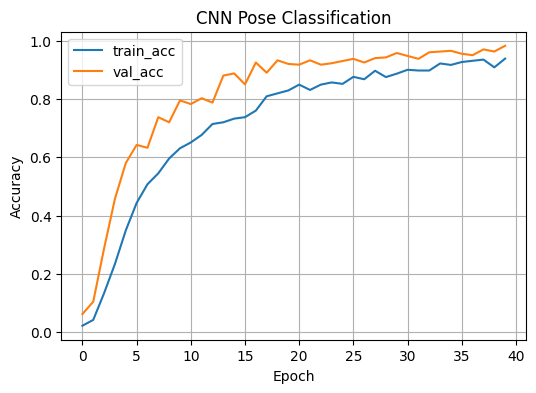

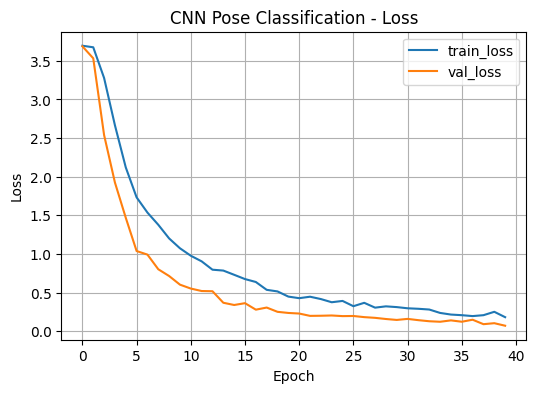

In [ ]:
# Simple CNN model for pose classification
tf.keras.backend.clear_session()

IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE

def cnn_pose(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=num_classes, dropout_rate=0.5):
    # Input image tensor
    inputs = keras.Input(shape=input_shape, name="input_image")

    # Apply data augmentation during training
    x = data_augmentation(inputs, training=True)

    # Explicit rescaling layer
    x = layers.Rescaling(1.0)(x)

    # Convolutional feature extractor
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Classification head
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)

    # Softmax over pose classes
    outputs = layers.Dense(num_classes, activation="softmax", name="pose_logits")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cnn_pose")
    return model


# Build model
model = cnn_pose()
model.summary()

# Compile with categorical cross-entropy for multi-class classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

# Save best model based on validation accuracy
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "cnn_pose_best.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1,
)

# Stop training early if validation loss stops improving
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

EPOCHS = 40

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1,
)

# Plot accuracy curves
plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Pose Classification")
plt.legend()
plt.grid(True)
plt.show()

# Plot loss curves
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Pose Classification - Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ResNet50 pose classification with early stopping and fine-tuning
tf.keras.backend.clear_session()

# Input shape and number of pose classes
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
NUM_CLASSES = num_classes


def to_resnet_inputs(x, y_onehot):
    # Apply training-time augmentation
    x = data_augmentation(x, training=True)


    # Scale to [0,255] and apply ResNet preprocessing
    x_255 = x * 255.0
    x_pp = preprocess_input(x_255)

    # Convert one-hot label to integer class index
    y_idx = tf.argmax(y_onehot, axis=-1)

    return x_pp, y_idx

# Prepare datasets for ResNet50
train_ds_resnet = train_ds.map(to_resnet_inputs, num_parallel_calls=tf_AUTOTUNE)
val_ds_resnet   = val_ds.map(to_resnet_inputs,   num_parallel_calls=tf_AUTOTUNE)
test_ds_resnet  = test_ds.map(to_resnet_inputs,  num_parallel_calls=tf_AUTOTUNE)

train_ds_resnet = train_ds_resnet.prefetch(tf_AUTOTUNE)
val_ds_resnet   = val_ds_resnet.prefetch(tf_AUTOTUNE)
test_ds_resnet  = test_ds_resnet.prefetch(tf_AUTOTUNE)

# Load pretrained ResNet50 backbone
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=INPUT_SHAPE,
)

# Freeze backbone for initial training
base_model.trainable = False

# Build classification head on top of ResNet50
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="resnet_input")
x = inputs
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pose_logits")(x)

resnet_model = keras.Model(inputs=inputs, outputs=outputs, name="resnet50_pose")
resnet_model.summary()

# Compile model with frozen backbone
resnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Callbacks for fine-tuning phase
earlystop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

checkpoint_cb = ModelCheckpoint(
    "resnet50_pose_best.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Initial training with frozen backbone
initial_epochs = 20
history_resnet = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=initial_epochs,
    verbose=1,
)

# Unfreeze last layers for fine-tuning
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

print(f"\nUnfreezing from layer {fine_tune_at} / {len(base_model.layers)} for fine-tuning...")

# Recompile with lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Continue training with unfrozen layers
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_resnet_ft = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=total_epochs,
    initial_epoch=history_resnet.epoch[-1],
    callbacks=[earlystop_cb, checkpoint_cb],
    verbose=1,
)

# Load best-performing fine-tuned weights
resnet_model.load_weights("resnet50_pose_best.keras")

# Final evaluation on test set
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_ds_resnet)
print(f"ResNet50 test accuracy: {test_acc_resnet:.4f}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50_pose"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet_input (InputLayer)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pose_logits (Dense)             │ (None, 40)             │        81,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,669,672 (90.29 MB)

 Trainable params: 81,960 (320.16 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 433ms/step - accuracy: 0.0472 - loss: 4.7763 - val_accuracy: 0.2600 - val_loss: 2.6119
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.1905 - loss: 3.0582 - val_accuracy: 0.4450 - val_loss: 1.9781
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.3441 - loss: 2.3270 - val_accuracy: 0.5300 - val_loss: 1.5968
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4353 - loss: 1.9268 - val_accuracy: 0.6150 - val_loss: 1.3576
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5249 - loss: 1.5686 - val_accuracy: 0.6150 - val_loss: 1.2376
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5874 - loss: 1.3329 - val_accuracy: 0.6700 - val_loss: 1.0910
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.6207 - loss: 1.1838 - val_accuracy: 0.7250 - val_loss: 0.9815
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6533 - loss: 1.1029 - val_accuracy: 0.7400 -

In [ ]:
# VGG16 baseline model with fine-tuning
tf.keras.backend.clear_session()

# Input shape for VGG16 (expects RGB images)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)


def to_vgg_inputs(x, y_onehot):
    # Apply training-time augmentation
    x = data_augmentation(x, training=True)

    # Scale from [0,1] to [0,255]
    x_255 = x * 255.0

    # Apply VGG16 preprocessing (BGR + mean subtraction)
    x_pp = vgg_preprocess(x_255)

    # Convert one-hot label to integer class index
    y_idx = tf.argmax(y_onehot, axis=-1)

    return x_pp, y_idx


# Prepare datasets for VGG16
train_ds_vgg = train_ds.map(to_vgg_inputs, num_parallel_calls=tf_AUTOTUNE)
val_ds_vgg   = val_ds.map(to_vgg_inputs,   num_parallel_calls=tf_AUTOTUNE)
test_ds_vgg  = test_ds.map(to_vgg_inputs,  num_parallel_calls=tf_AUTOTUNE)

train_ds_vgg = train_ds_vgg.prefetch(tf_AUTOTUNE)
val_ds_vgg   = val_ds_vgg.prefetch(tf_AUTOTUNE)
test_ds_vgg  = test_ds_vgg.prefetch(tf_AUTOTUNE)


# Build VGG16-based pose classifier
def pose_vgg16(input_shape, num_classes):
    # Load pretrained VGG16 backbone
    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )

    # Freeze backbone for initial training
    base_model.trainable = False

    # Classification head
    inputs = base_model.input
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name="vgg16_pose"
    )

    return model, base_model


pose_vgg, vgg_base = pose_vgg16(INPUT_SHAPE, NUM_CLASSES)
pose_vgg.summary()


# Initial training with frozen VGG16 backbone
pose_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Callbacks for initial training
# Stage 1 callbacks
checkpoint_cb_stage1 = ModelCheckpoint(
    "pose_vgg16_stage1_best.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

earlystop_cb_stage1 = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=5,
    restore_best_weights=True,
)

vgg_epochs = 15

# Fit stage 1
history_vgg = pose_vgg.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=vgg_epochs,
    callbacks=[checkpoint_cb_stage1, earlystop_cb_stage1],
    verbose=1,
)

# Restore best weights before fine-tuning
pose_vgg.load_weights("pose_vgg16_stage1_best.keras")


# Fine-tuning setup: unfreeze top VGG16 layers
fine_tune_at = len(vgg_base.layers) - 8

for layer in vgg_base.layers[:fine_tune_at]:
    layer.trainable = False
for layer in vgg_base.layers[fine_tune_at:]:
    layer.trainable = True

print(f"\nUnfreezing from layer {fine_tune_at} / {len(vgg_base.layers)} for fine-tuning...")

# Recompile with lower learning rate for fine-tuning
pose_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Callbacks for fine-tuning stage
# Stage 2 callbacks (fine-tuning)
checkpoint_cb_stage2 = ModelCheckpoint(
    "pose_vgg16_stage2_best.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

earlystop_cb_stage2 = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

fine_tune_epochs = 30
total_epochs = vgg_epochs + fine_tune_epochs


# Fine-tuning training
# Fit stage 2
history_vgg_ft = pose_vgg.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=total_epochs,
    initial_epoch=history_vgg.epoch[-1],
    callbacks=[checkpoint_cb_stage2, earlystop_cb_stage2],
    verbose=1,
)


# Final evaluation on test set
pose_vgg.load_weights("pose_vgg16_stage2_best.keras")

test_loss_vgg, test_acc_vgg = pose_vgg.evaluate(test_ds_vgg, verbose=1)
print(f"\n[VGG16 Pose] Test accuracy (after fine-tuning): {test_acc_vgg:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16_pose"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,735,208 (56.21 MB)

 Trainable params: 20,520 (80.16 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.0253 - loss: 10.4569 - val_accuracy: 0.0525 - val_loss: 4.2239
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.0536 - loss: 7.5300 - val_accuracy: 0.1650 - val_loss: 3.1195
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.0947 - loss: 6.2054 - val_accuracy: 0.2675 - val_loss: 2.4747
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.1464 - loss: 5.0833 - val_accuracy: 0.3975 - val_loss: 2.0815
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.1658 - loss: 4.4114 - val_accuracy: 0.4825 - val_loss: 1.7474
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.2360 - loss: 3.5973 - val_accuracy: 0.5775 - val_loss: 1.5245
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.2804 - loss: 3.1202 - val_accuracy: 0.6050 - val_loss: 1.2925
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.3385 - loss: 2.6234 - val_accuracy: 0.6900 

In [ ]:
# Optimised CNN for pose classification (L2 + dropout + LR scheduling)


tf.keras.backend.clear_session()

def cnn_pose_optimised(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=num_classes,
    dropout_rate=0.5,
    l2_strength=1e-4,
):
    # Model input
    inputs = keras.Input(shape=input_shape, name="input_image")

    # Apply augmentation during training
    x = data_augmentation(inputs, training=True)

    # Keep explicit rescaling layer
    x = layers.Rescaling(1.0)(x)

    # Shared L2 regularizer for conv + dense layers
    reg = regularizers.l2(l2_strength)

    # Convolutional feature extractor with L2 regularization
    x = layers.Conv2D(32, 3, padding="same", activation="relu",
                      kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu",
                      kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu",
                      kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu",
                      kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Classification head
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Softmax output over pose classes
    outputs = layers.Dense(num_classes, activation="softmax",
                           name="pose_logits")(x)

    model = keras.Model(inputs=inputs, outputs=outputs,
                        name="cnn_pose_optimised")
    return model


# Build and inspect model
cnn_opt = cnn_pose_optimised()
cnn_opt.summary()

# Compile for multi-class classification (one-hot labels)
cnn_opt.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

# Training callbacks: best checkpoint, early stop, and LR reduction on plateau
cnn_opt_callbacks = [
    keras.callbacks.ModelCheckpoint(
        "cnn_pose_optimised_best.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=8,
        restore_best_weights=True,
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    ),
]

EPOCHS_OPT_CNN = 40

# Train optimised CNN
history_cnn_opt = cnn_opt.fit(
    train_ds,
    epochs=EPOCHS_OPT_CNN,
    validation_data=val_ds,
    callbacks=cnn_opt_callbacks,
    verbose=1,
)

Model: "cnn_pose_optimised"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_9            │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pose_logits (Dense)             │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,200,296 (16.02 MB)

 Trainable params: 4,200,296 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0251 - loss: 3.7916
Epoch 1: val_accuracy improved from -inf to 0.07500, saving model to cnn_pose_optimised_best.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.0248 - loss: 3.7912 - val_accuracy: 0.0750 - val_loss: 3.7644 - learning_rate: 3.0000e-04
Epoch 2/40
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0472 - loss: 3.7587
Epoch 2: val_accuracy improved from 0.07500 to 0.08000, saving model to cnn_pose_optimised_best.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0470 - loss: 3.7584 - val_accuracy: 0.0800 - val_loss: 3.7238 - learning_rate: 3.0000e-04
Epoch 3/40
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0715 - loss: 3.6628
Epoch 3: val_accuracy improved from 0.08000 to 0.21000, saving model to cnn_pose_optimised_best.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0720 - loss: 3.6585 - val_accuracy: 0.2100 - val_loss: 3.0887 - learning_rate: 3.0000e-04
Epoch 4/40

In [ ]:
# Optimised ResNet50 pose classifier (2-stage: frozen head training then fine-tuning)

tf.keras.backend.clear_session()

# Reuse: to_resnet_inputs, train_ds_resnet, val_ds_resnet, test_ds_resnet

INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
NUM_CLASSES = num_classes

# ResNet50 backbone (ImageNet pretrained)
base_model_opt = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=INPUT_SHAPE,
)
base_model_opt.trainable = False  # freeze for stage 1

# Classification head
inputs_rn = keras.Input(shape=INPUT_SHAPE, name="resnet_input_opt")
x = inputs_rn
x = base_model_opt(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.Dropout(0.5)(x)
outputs_rn = layers.Dense(NUM_CLASSES, activation="softmax",
                          name="pose_logits")(x)

resnet_opt = keras.Model(inputs=inputs_rn, outputs=outputs_rn,
                         name="resnet50_pose_optimised")
resnet_opt.summary()

# Save best model weights during training
checkpoint_cb_opt = ModelCheckpoint(
    "resnet50_pose_opt_best.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Stage 1: train classifier head with frozen backbone
resnet_opt.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

rn_opt_callbacks_stage1 = [
    # Stop if validation accuracy stops improving
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
    # Keep best weights during stage 1
    checkpoint_cb_opt,
]

RN_EPOCHS_STAGE1 = 25
history_resnet_opt_stage1 = resnet_opt.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=RN_EPOCHS_STAGE1,
    callbacks=rn_opt_callbacks_stage1,
    verbose=1,
)

# Restore best stage 1 checkpoint before fine-tuning
resnet_opt.load_weights("resnet50_pose_opt_best.keras")

# Stage 2: fine-tune last 30 layers with smaller LR + LR schedule
fine_tune_at_opt = len(base_model_opt.layers) - 30

for layer in base_model_opt.layers[:fine_tune_at_opt]:
    layer.trainable = False
for layer in base_model_opt.layers[fine_tune_at_opt:]:
    layer.trainable = True

# Recompile after changing trainable layers
resnet_opt.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

rn_opt_callbacks_stage2 = [
    # Stop if validation loss stops improving
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=10,
        restore_best_weights=True,
        verbose=1,
    ),
    # Reduce learning rate when validation accuracy plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1,
    ),
    # Keep best weights across fine-tuning
    checkpoint_cb_opt,
]

RN_EPOCHS_STAGE2 = 30
history_resnet_opt_stage2 = resnet_opt.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=RN_EPOCHS_STAGE1 + RN_EPOCHS_STAGE2,
    initial_epoch=history_resnet_opt_stage1.epoch[-1],
    callbacks=rn_opt_callbacks_stage2,
    verbose=1,
)

Model: "resnet50_pose_optimised"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet_input_opt (InputLayer)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pose_logits (Dense)             │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,536 (92.02 MB)

 Trainable params: 534,824 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 537ms/step - accuracy: 0.0307 - loss: 4.6653 - val_accuracy: 0.1000 - val_loss: 3.5135
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.0855 - loss: 3.5546 - val_accuracy: 0.2100 - val_loss: 3.1662
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.1194 - loss: 3.2307 - val_accuracy: 0.3125 - val_loss: 2.7235
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.1751 - loss: 3.0098 - val_accuracy: 0.3550 - val_loss: 2.3673
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.2341 - loss: 2.6806 - val_accuracy: 0.4550 - val_loss: 2.0899
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.2699 - loss: 2.5084 - val_accuracy: 0.4700 - val_loss: 1.8603
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.2978 - loss: 2.2763 - val_accuracy: 0.5675 - val_loss: 1.7135
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.3577 - loss: 2.1322 - val_accuracy: 0.5650 -

In [ ]:
# Optimised VGG16 pose classifier (2-stage: frozen head training then fine-tuning)

tf.keras.backend.clear_session()

# Reuse: to_vgg_inputs, train_ds_vgg, val_ds_vgg, test_ds_vgg

def pose_vgg16_optimised(input_shape, num_classes):
    # VGG16 backbone
    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    base_model.trainable = False  # freeze for stage 1

    # Classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Extra dense layer with L2 regularization
    x = layers.Dense(
        256,
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=base_model.input,
                        outputs=outputs,
                        name="vgg16_pose_optimised")
    return model, base_model


# Build and inspect model
vgg_opt, vgg_base_opt = pose_vgg16_optimised(
    (IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES
)
vgg_opt.summary()

# Checkpoint path for saving best weights
VGG_OPT_CKPT_PATH = "vgg16_pose_opt_best.keras"

checkpoint_cb_opt = ModelCheckpoint(
    VGG_OPT_CKPT_PATH,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Stage 1: train classifier head with frozen backbone
vgg_opt.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

vgg_opt_callbacks_stage1 = [
    # Stop if validation accuracy stops improving
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
    # Save best weights during stage 1
    checkpoint_cb_opt,
]

VGG_EPOCHS_STAGE1 = 15
history_vgg_opt_stage1 = vgg_opt.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=VGG_EPOCHS_STAGE1,
    callbacks=vgg_opt_callbacks_stage1,
    verbose=1,
)

# Restore best stage 1 checkpoint before fine-tuning
vgg_opt.load_weights(VGG_OPT_CKPT_PATH)

# Stage 2: fine-tune last 8 VGG16 layers with smaller LR + LR schedule
fine_tune_at_vgg = len(vgg_base_opt.layers) - 8

for layer in vgg_base_opt.layers[:fine_tune_at_vgg]:
    layer.trainable = False
for layer in vgg_base_opt.layers[fine_tune_at_vgg:]:
    layer.trainable = True

# Recompile after changing trainable layers
vgg_opt.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

vgg_opt_callbacks_stage2 = [
    # Stop if validation loss stops improving
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=10,
        restore_best_weights=True,
        verbose=1,
    ),
    # Reduce learning rate when validation accuracy plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1,
    ),
    # Save best weights across fine-tuning
    checkpoint_cb_opt,
]

VGG_EPOCHS_STAGE2 = 30
history_vgg_opt_stage2 = vgg_opt.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=VGG_EPOCHS_STAGE1 + VGG_EPOCHS_STAGE2,
    initial_epoch=history_vgg_opt_stage1.epoch[-1],
    callbacks=vgg_opt_callbacks_stage2,
    verbose=1,
)

Model: "vgg16_pose_optimised"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,856,296 (56.67 MB)

 Trainable params: 141,608 (553.16 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - accuracy: 0.0262 - loss: 9.6771 - val_accuracy: 0.0525 - val_loss: 3.6647
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.0437 - loss: 4.2646 - val_accuracy: 0.0500 - val_loss: 3.7098
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.0507 - loss: 3.8938 - val_accuracy: 0.0450 - val_loss: 3.7130
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.0440 - loss: 3.7156 - val_accuracy: 0.0625 - val_loss: 3.6853
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.0454 - loss: 3.6840 - val_accuracy: 0.0825 - val_loss: 3.6451
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.0462 - loss: 3.6301 - val_accuracy: 0.1400 - val_loss: 3.6016
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.0695 - loss: 3.5644 - val_accuracy: 0.1775 - val_loss: 3.4250
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.0798 - loss: 3.4663 - val_accuracy: 0.2275 -


===== CNN (pose) on TEST set =====
Accuracy          : 0.9800
Macro Precision   : 0.9824
Macro Recall      : 0.9800
Macro F1          : 0.9798
Weighted Precision: 0.9824
Weighted Recall   : 0.9800
Weighted F1       : 0.9798

Classification report:
              precision    recall  f1-score   support

           0      0.909     1.000     0.952        10
           1      0.750     0.900     0.818        10
           2      1.000     0.700     0.824        10
           3      1.000     1.000     1.000        10
           4      1.000     1.000     1.000        10
           5      0.909     1.000     0.952        10
           6      1.000     1.000     1.000        10
           7      1.000     1.000     1.000        10
           8      1.000     1.000     1.000        10
           9      1.000     1.000     1.000        10
          10      1.000     0.900     0.947        10
          11      1.000     1.000     1.000        10
          12      1.000     1.000     1.000     

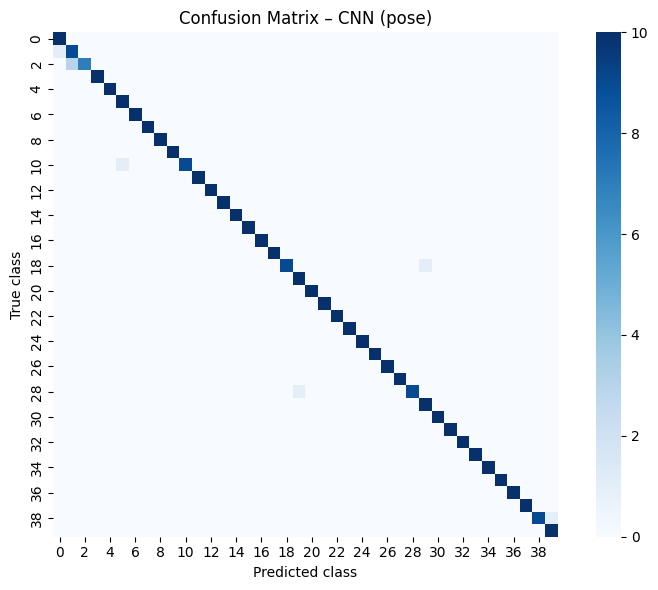


===== ResNet50 on TEST set =====
Accuracy          : 0.9650
Macro Precision   : 0.9688
Macro Recall      : 0.9650
Macro F1          : 0.9648
Weighted Precision: 0.9688
Weighted Recall   : 0.9650
Weighted F1       : 0.9648

Classification report:
              precision    recall  f1-score   support

           0      0.909     1.000     0.952        10
           1      0.909     1.000     0.952        10
           2      1.000     0.800     0.889        10
           3      1.000     1.000     1.000        10
           4      1.000     1.000     1.000        10
           5      1.000     1.000     1.000        10
           6      1.000     0.700     0.824        10
           7      0.769     1.000     0.870        10
           8      1.000     1.000     1.000        10
           9      1.000     0.900     0.947        10
          10      0.909     1.000     0.952        10
          11      1.000     0.900     0.947        10
          12      1.000     1.000     1.000       

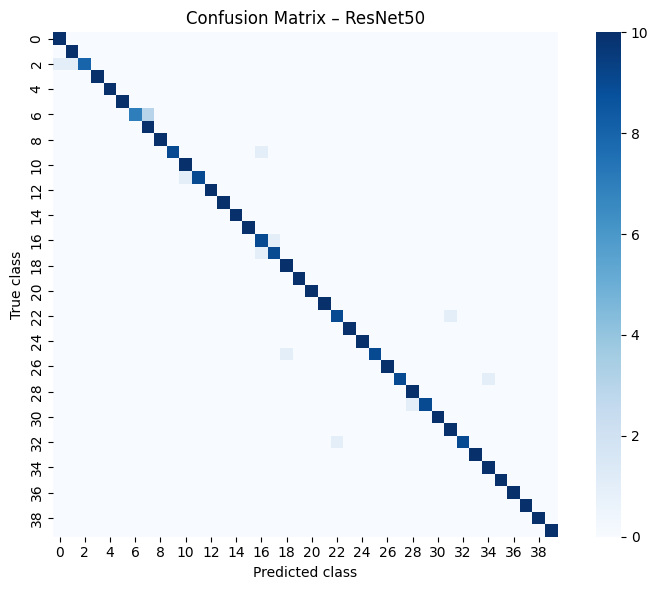


===== VGG16 on TEST set =====
Accuracy          : 0.9800
Macro Precision   : 0.9822
Macro Recall      : 0.9800
Macro F1          : 0.9798
Weighted Precision: 0.9822
Weighted Recall   : 0.9800
Weighted F1       : 0.9798

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.900     0.947        10
           1      0.900     0.900     0.900        10
           2      1.000     1.000     1.000        10
           3      1.000     1.000     1.000        10
           4      1.000     1.000     1.000        10
           5      1.000     1.000     1.000        10
           6      1.000     0.700     0.824        10
           7      0.769     1.000     0.870        10
           8      0.909     1.000     0.952        10
           9      0.900     0.900     0.900        10
          10      1.000     0.900     0.947        10
          11      0.909     1.000     0.952        10
          12      1.000     1.000     1.000        10

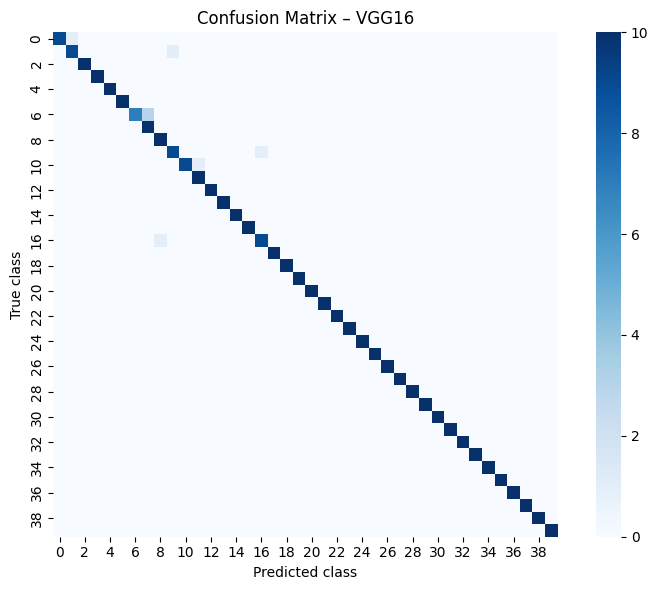


======= Pose Classification – Model Comparison =======
     Model  Test Accuracy  Macro F1  Macro Precision  Macro Recall  Best Val Accuracy  Best Val Loss
CNN (pose)         0.9800    0.9798           0.9824        0.9800             0.9825         0.0718
     VGG16         0.9800    0.9798           0.9822        0.9800             0.8100         0.6965
  ResNet50         0.9650    0.9648           0.9688        0.9650             0.9400         0.1651


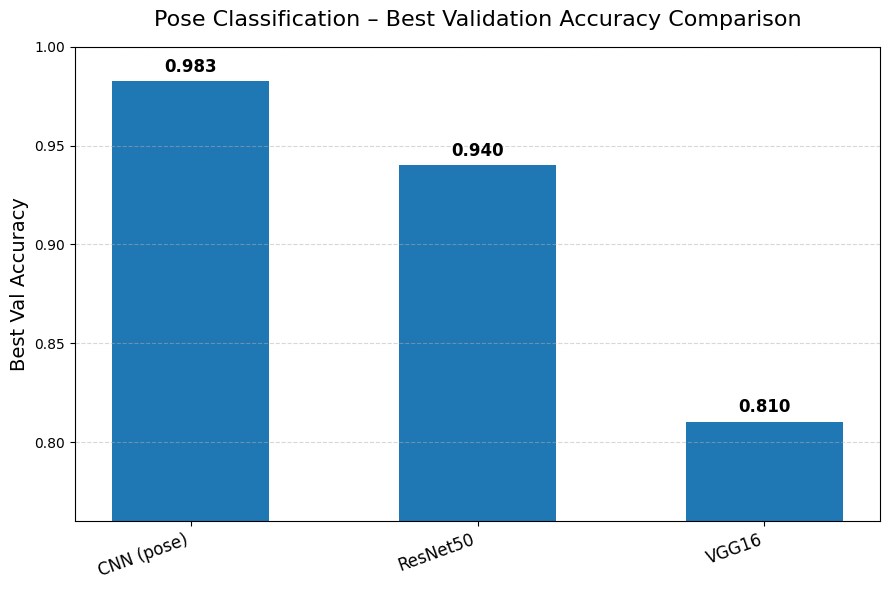

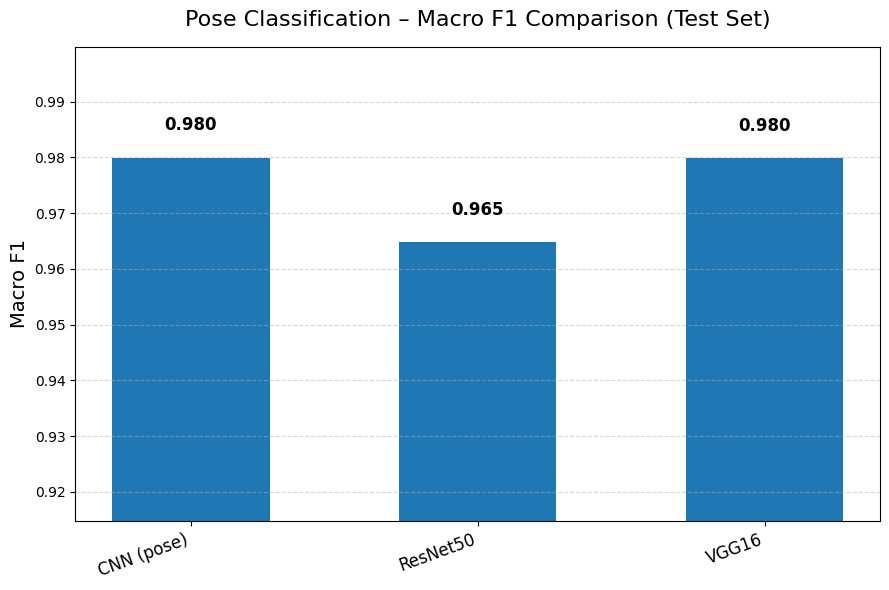

In [ ]:
# Baseline model evaluation: accuracy, precision, recall, F1, confusion matrix, and summary plots

def get_preds_and_labels(model, dataset):
    all_true = []
    all_pred = []

    for images, labels in dataset:
        logits = model(images, training=False)      # (batch, num_classes)
        preds = tf.argmax(logits, axis=1)           # predicted class ids

        # Convert labels to class ids
        if len(labels.shape) > 1:                   # (batch, num_classes)
            true_ids = tf.argmax(labels, axis=1)
        else:                                       # (batch,)
            true_ids = labels

        all_true.append(true_ids.numpy())
        all_pred.append(preds.numpy())

    y_true = np.concatenate(all_true, axis=0)
    y_pred = np.concatenate(all_pred, axis=0)
    return y_true, y_pred


def evaluate_model(model, dataset, name):

    print(f"\n===== {name} on TEST set =====")
    y_true, y_pred = get_preds_and_labels(model, dataset)

    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)

    # Macro averages
    prec_macro  = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro   = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_macro    = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # Weighted averages
    prec_weight = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_weight  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1_weight   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"Accuracy          : {acc:.4f}")
    print(f"Macro Precision   : {prec_macro:.4f}")
    print(f"Macro Recall      : {rec_macro:.4f}")
    print(f"Macro F1          : {f1_macro:.4f}")
    print(f"Weighted Precision: {prec_weight:.4f}")
    print(f"Weighted Recall   : {rec_weight:.4f}")
    print(f"Weighted F1       : {f1_weight:.4f}")

    # Per-class precision/recall/F1 breakdown
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

    # Confusion matrix heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap="Blues", square=True, cbar=True)
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.tight_layout()
    plt.show()

    # Summary metrics for table/plots
    return {
        "Model": name,
        "Test Accuracy": acc,
        "Macro F1": f1_macro,
        "Macro Precision": prec_macro,
        "Macro Recall": rec_macro,
    }


def best_val_stats(history, acc_keys=("val_acc", "val_accuracy")):
    val_acc_key = None
    for k in acc_keys:
        if k in history.history:
            val_acc_key = k
            break

    if val_acc_key is None:
        best_val_acc = np.nan
    else:
        best_val_acc = np.max(history.history[val_acc_key])

    if "val_loss" in history.history:
        best_val_loss = np.min(history.history["val_loss"])
    else:
        best_val_loss = np.nan

    return best_val_acc, best_val_loss


# Evaluate each trained model and collect results
summary_rows = []

# 1) CNN
row_cnn = evaluate_model(model, test_ds, "CNN (pose)")
best_acc_cnn, best_loss_cnn = best_val_stats(history, acc_keys=("val_accuracy", "val_acc"))
row_cnn["Best Val Accuracy"] = best_acc_cnn
row_cnn["Best Val Loss"]     = best_loss_cnn
summary_rows.append(row_cnn)

# 2) ResNet50
row_resnet = evaluate_model(resnet_model, test_ds_resnet, "ResNet50")
best_acc_resnet, best_loss_resnet = best_val_stats(history_resnet_ft, acc_keys=("val_accuracy", "val_acc"))
row_resnet["Best Val Accuracy"] = best_acc_resnet
row_resnet["Best Val Loss"]     = best_loss_resnet
summary_rows.append(row_resnet)

# 3) VGG16
row_vgg = evaluate_model(pose_vgg, test_ds_vgg, "VGG16")
best_acc_vgg, best_loss_vgg = best_val_stats(history_vgg, acc_keys=("val_accuracy", "val_acc"))
row_vgg["Best Val Accuracy"] = best_acc_vgg
row_vgg["Best Val Loss"]     = best_loss_vgg
summary_rows.append(row_vgg)

# Build comparison table
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="Test Accuracy", ascending=False)

print("\n======= Pose Classification – Model Comparison =======")
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Rebuild table and sort by best validation accuracy for plotting
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="Best Val Accuracy", ascending=False)

# Bar plot: best validation accuracy per model
import numpy as np

plt.figure(figsize=(9, 6))

models = summary_df["Model"].values
val_accuracies = summary_df["Best Val Accuracy"].values

x = np.arange(len(models))
bar_width = 0.55

plt.bar(x, val_accuracies, width=bar_width)

plt.title("Pose Classification – Best Validation Accuracy Comparison", fontsize=16, pad=15)
plt.ylabel("Best Val Accuracy", fontsize=14)
plt.xticks(x, models, rotation=20, ha="right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Y-limits with a small margin for label readability
y_min = max(0.0, val_accuracies.min() - 0.05)
y_max = min(1.0, val_accuracies.max() + 0.02)
plt.ylim(y_min, y_max)

for i, val in enumerate(val_accuracies):
    plt.text(
        x=i,
        y=val + 0.005,
        s=f"{val:.3f}",
        ha="center",
        fontsize=12,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

# Bar plot: macro F1 comparison (test set)
plt.figure(figsize=(9, 6))

macro_f1 = summary_df["Macro F1"].values

x = np.arange(len(models))
plt.bar(x, macro_f1, width=0.55)

plt.title("Pose Classification – Macro F1 Comparison (Test Set)", fontsize=16, pad=15)
plt.ylabel("Macro F1", fontsize=14)
plt.xticks(x, models, rotation=20, ha="right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

y_min = max(0.0, macro_f1.min() - 0.05)
y_max = min(1.0, macro_f1.max() + 0.02)
plt.ylim(y_min, y_max)

for i, val in enumerate(macro_f1):
    plt.text(
        x=i,
        y=val + 0.005,
        s=f"{val:.3f}",
        ha="center",
        fontsize=12,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


===== CNN (pose, optimised) on TEST set =====
Accuracy          : 0.9775
Macro Precision   : 0.9795
Macro Recall      : 0.9775
Macro F1          : 0.9773
Weighted Precision: 0.9795
Weighted Recall   : 0.9775
Weighted F1       : 0.9773

Classification report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        10
           1      0.900     0.900     0.900        10
           2      0.900     0.900     0.900        10
           3      1.000     1.000     1.000        10
           4      1.000     1.000     1.000        10
           5      0.909     1.000     0.952        10
           6      1.000     0.800     0.889        10
           7      1.000     1.000     1.000        10
           8      1.000     0.900     0.947        10
           9      0.909     1.000     0.952        10
          10      1.000     0.900     0.947        10
          11      1.000     1.000     1.000        10
          12      0.833     1.000    

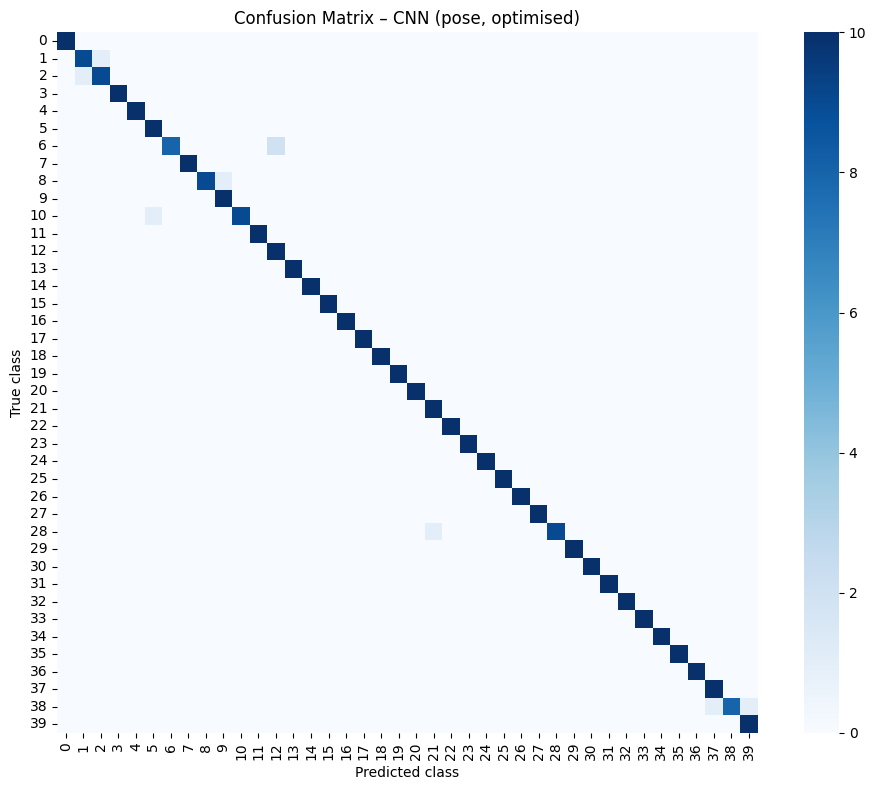


===== ResNet50 (optimised) on TEST set =====
Accuracy          : 0.9175
Macro Precision   : 0.9269
Macro Recall      : 0.9175
Macro F1          : 0.9170
Weighted Precision: 0.9269
Weighted Recall   : 0.9175
Weighted F1       : 0.9170

Classification report:
              precision    recall  f1-score   support

           0      0.769     1.000     0.870        10
           1      1.000     0.900     0.947        10
           2      0.857     0.600     0.706        10
           3      0.900     0.900     0.900        10
           4      1.000     1.000     1.000        10
           5      1.000     1.000     1.000        10
           6      1.000     0.800     0.889        10
           7      0.833     1.000     0.909        10
           8      0.875     0.700     0.778        10
           9      0.571     0.800     0.667        10
          10      0.692     0.900     0.783        10
          11      0.857     0.600     0.706        10
          12      1.000     1.000     

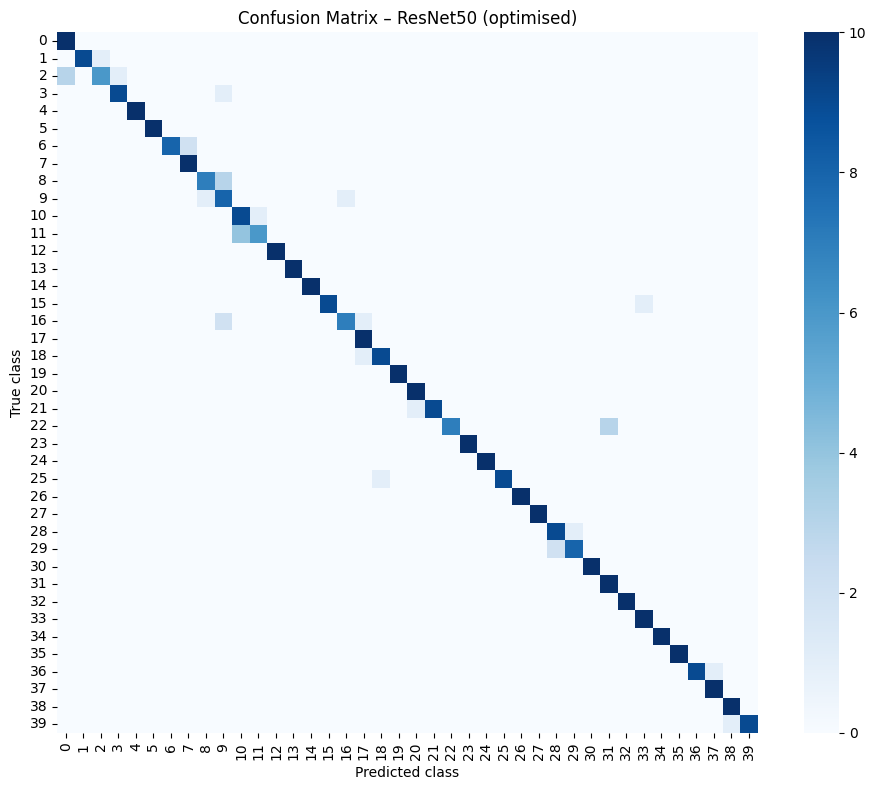


===== VGG16 (optimised) on TEST set =====
Accuracy          : 0.9400
Macro Precision   : 0.9486
Macro Recall      : 0.9400
Macro F1          : 0.9390
Weighted Precision: 0.9486
Weighted Recall   : 0.9400
Weighted F1       : 0.9390

Classification report:
              precision    recall  f1-score   support

           0      0.750     0.900     0.818        10
           1      0.909     1.000     0.952        10
           2      0.875     0.700     0.778        10
           3      1.000     0.900     0.947        10
           4      1.000     1.000     1.000        10
           5      1.000     1.000     1.000        10
           6      1.000     0.700     0.824        10
           7      0.769     1.000     0.870        10
           8      0.909     1.000     0.952        10
           9      1.000     0.900     0.947        10
          10      0.875     0.700     0.778        10
          11      0.750     0.900     0.818        10
          12      1.000     1.000     1.0

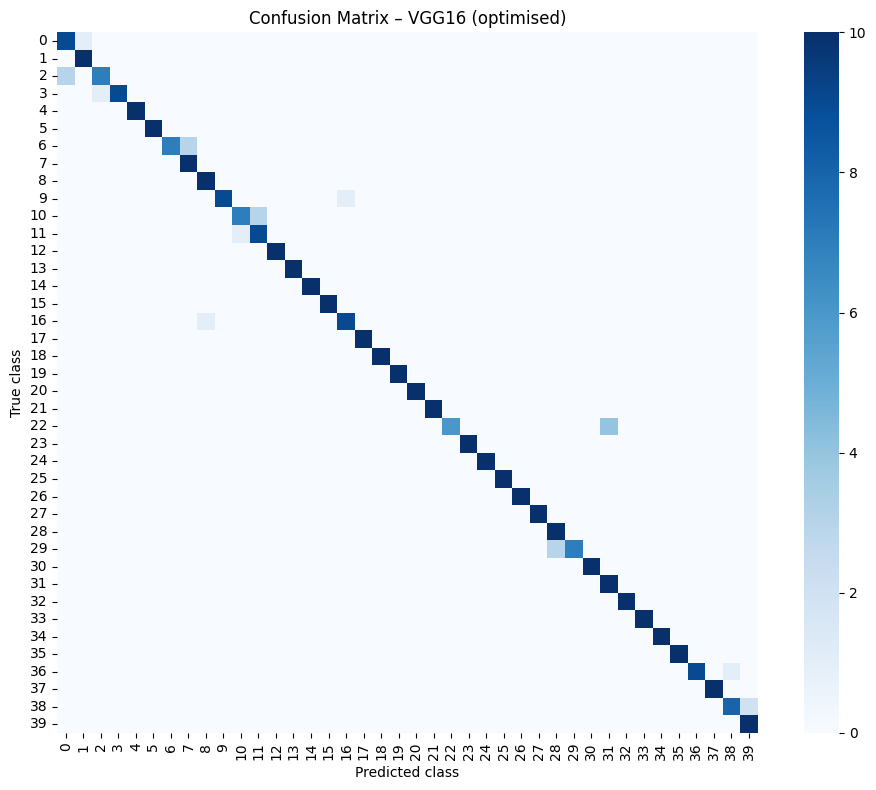


Pose Classification – Optimized Model Comparison
                Model  Test Accuracy  Macro F1  Macro Precision  Macro Recall  Best Val Accuracy  Best Val Loss
CNN (pose, optimised)         0.9775    0.9773           0.9795        0.9775             0.9750         0.1554
    VGG16 (optimised)         0.9400    0.9390           0.9486        0.9400             0.9075         0.3149
 ResNet50 (optimised)         0.9175    0.9170           0.9269        0.9175             0.9075         0.3438


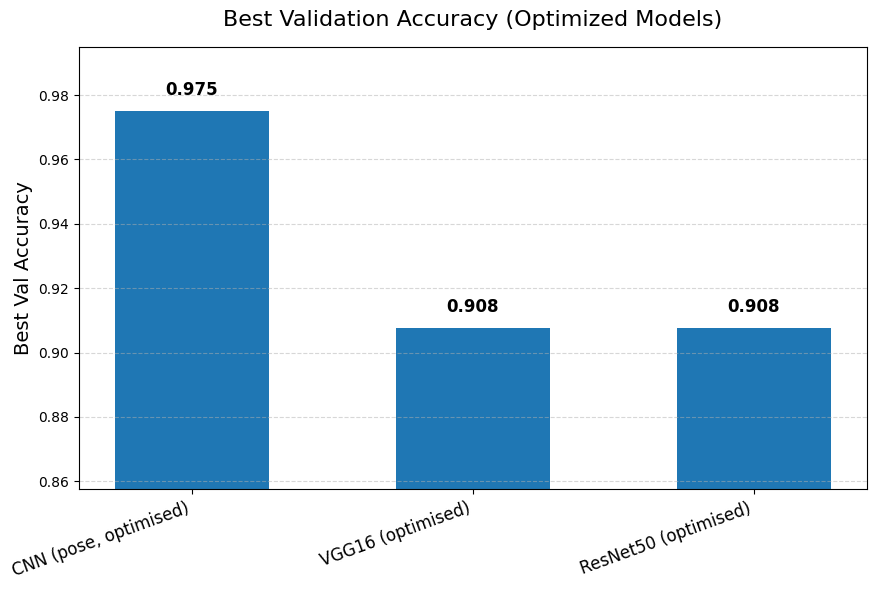

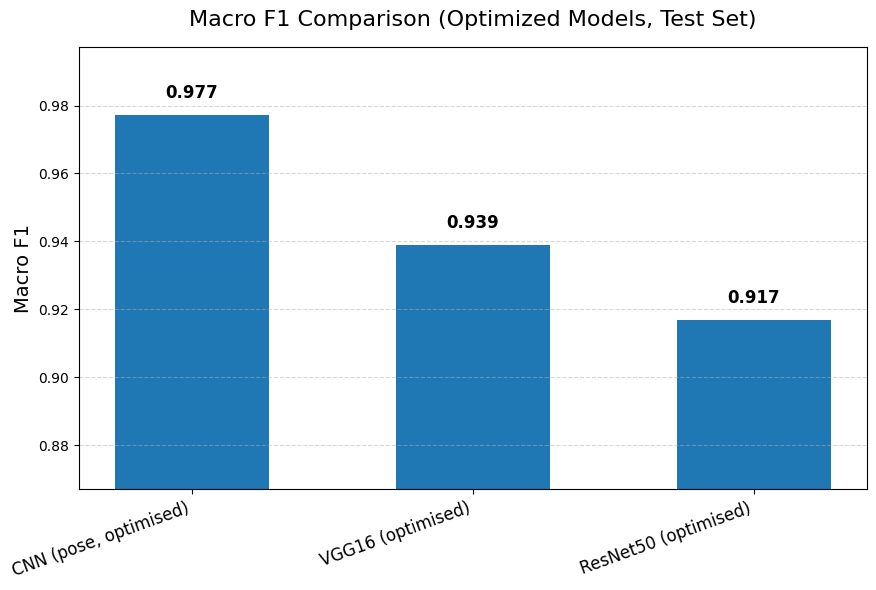

In [ ]:
# Optimized model evaluation: accuracy, precision, recall, F1, confusion matrix

def get_preds_and_labels(model, dataset):
    # Run model on dataset and collect true and predicted class ids
    all_true = []
    all_pred = []

    for images, labels in dataset:
        logits = model(images, training=False)
        preds = tf.argmax(logits, axis=1)

        # Handle one-hot or integer labels
        if len(labels.shape) > 1:
            true_ids = tf.argmax(labels, axis=1)
        else:
            true_ids = labels

        all_true.append(true_ids.numpy())
        all_pred.append(preds.numpy())

    y_true = np.concatenate(all_true, axis=0)
    y_pred = np.concatenate(all_pred, axis=0)
    return y_true, y_pred


def evaluate_model(model, dataset, name):
    # Compute metrics and show confusion matrix for a model
    print(f"\n===== {name} on TEST set =====")
    y_true, y_pred = get_preds_and_labels(model, dataset)

    acc = accuracy_score(y_true, y_pred)

    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)

    prec_weight = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_weight  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1_weight   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"Accuracy          : {acc:.4f}")
    print(f"Macro Precision   : {prec_macro:.4f}")
    print(f"Macro Recall      : {rec_macro:.4f}")
    print(f"Macro F1          : {f1_macro:.4f}")
    print(f"Weighted Precision: {prec_weight:.4f}")
    print(f"Weighted Recall   : {rec_weight:.4f}")
    print(f"Weighted F1       : {f1_weight:.4f}")

    # Per-class breakdown
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        cmap="Blues",
        square=True,
        cbar=True,
        fmt="d",
        xticklabels=range(NUM_CLASSES),
        yticklabels=range(NUM_CLASSES),
    )
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.tight_layout()
    plt.show()

    return {
        "Model": name,
        "Test Accuracy": acc,
        "Macro F1": f1_macro,
        "Macro Precision": prec_macro,
        "Macro Recall": rec_macro,
    }


def best_val_stats(history, acc_keys=("val_acc", "val_accuracy")):
    # Extract best validation accuracy and minimum validation loss
    val_acc_key = None
    for k in acc_keys:
        if k in history.history:
            val_acc_key = k
            break

    best_val_acc = (
        np.max(history.history[val_acc_key]) if val_acc_key else np.nan
    )
    best_val_loss = (
        np.min(history.history["val_loss"])
        if "val_loss" in history.history else np.nan
    )

    return best_val_acc, best_val_loss


# Evaluate each optimized model
summary_rows_opt = []

row_cnn_opt = evaluate_model(cnn_opt, test_ds, "CNN (pose, optimised)")
best_acc_cnn_opt, best_loss_cnn_opt = best_val_stats(history_cnn_opt)
row_cnn_opt["Best Val Accuracy"] = best_acc_cnn_opt
row_cnn_opt["Best Val Loss"] = best_loss_cnn_opt
summary_rows_opt.append(row_cnn_opt)

row_resnet_opt = evaluate_model(resnet_opt, test_ds_resnet, "ResNet50 (optimised)")
best_acc_resnet_opt, best_loss_resnet_opt = best_val_stats(history_resnet_opt_stage2)
row_resnet_opt["Best Val Accuracy"] = best_acc_resnet_opt
row_resnet_opt["Best Val Loss"] = best_loss_resnet_opt
summary_rows_opt.append(row_resnet_opt)

row_vgg_opt = evaluate_model(vgg_opt, test_ds_vgg, "VGG16 (optimised)")
best_acc_vgg_opt, best_loss_vgg_opt = best_val_stats(history_vgg_opt_stage2)
row_vgg_opt["Best Val Accuracy"] = best_acc_vgg_opt
row_vgg_opt["Best Val Loss"] = best_loss_vgg_opt
summary_rows_opt.append(row_vgg_opt)


# Build comparison table
summary_df_opt = pd.DataFrame(summary_rows_opt)
summary_df_opt = summary_df_opt.sort_values(by="Test Accuracy", ascending=False)

print("\nPose Classification – Optimized Model Comparison")
print(summary_df_opt.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


# Bar plot: best validation accuracy
plt.figure(figsize=(9, 6))

models = summary_df_opt["Model"].values
val_accuracies = summary_df_opt["Best Val Accuracy"].values

x = np.arange(len(models))
plt.bar(x, val_accuracies, width=0.55)

plt.title("Best Validation Accuracy (Optimized Models)", fontsize=16, pad=15)
plt.ylabel("Best Val Accuracy", fontsize=14)
plt.xticks(x, models, rotation=20, ha="right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.ylim(
    max(0.0, val_accuracies.min() - 0.05),
    min(1.0, val_accuracies.max() + 0.02),
)

for i, val in enumerate(val_accuracies):
    plt.text(i, val + 0.005, f"{val:.3f}", ha="center", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()


# Bar plot: macro F1 score
plt.figure(figsize=(9, 6))

macro_f1 = summary_df_opt["Macro F1"].values
plt.bar(x, macro_f1, width=0.55)

plt.title("Macro F1 Comparison (Optimized Models, Test Set)", fontsize=16, pad=15)
plt.ylabel("Macro F1", fontsize=14)
plt.xticks(x, models, rotation=20, ha="right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.ylim(
    max(0.0, macro_f1.min() - 0.05),
    min(1.0, macro_f1.max() + 0.02),
)

for i, val in enumerate(macro_f1):
    plt.text(i, val + 0.005, f"{val:.3f}", ha="center", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()


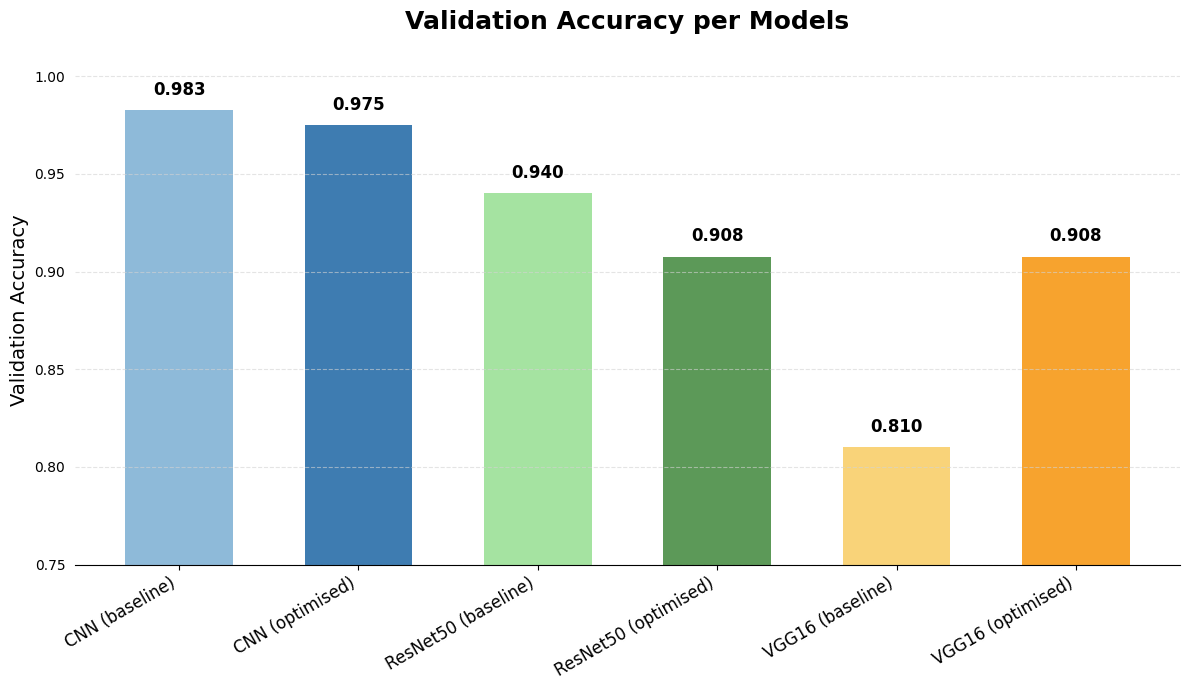

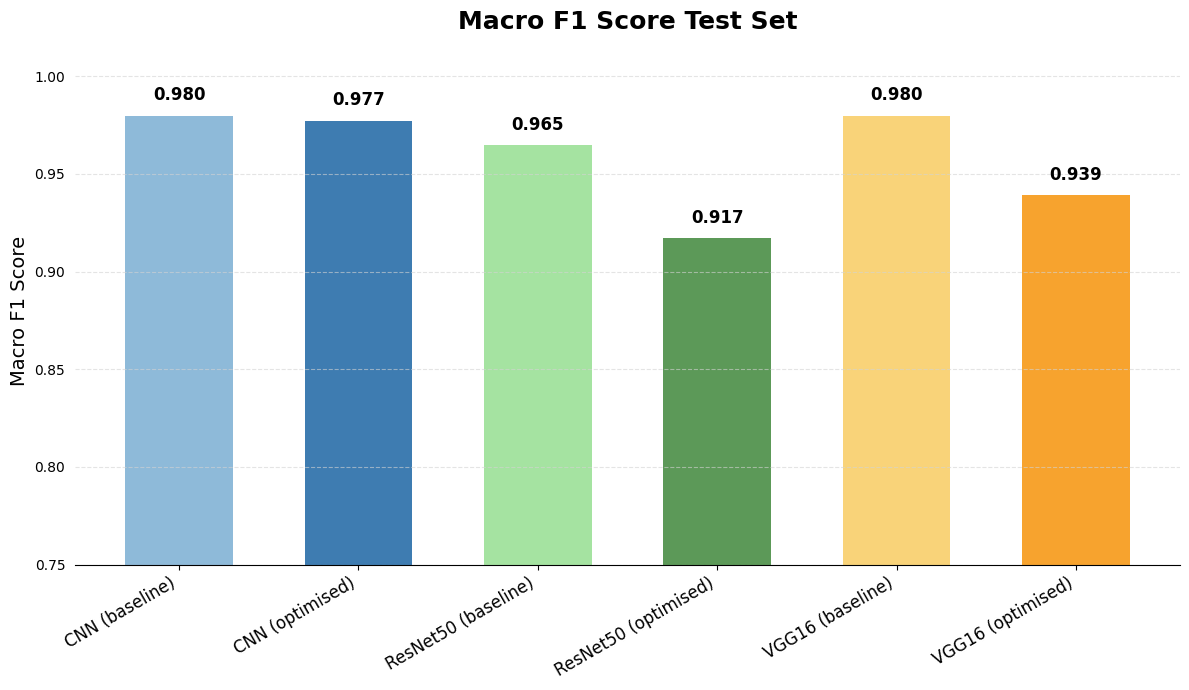

In [ ]:
# Combine baseline and optimised summary tables

summary_df["Variant"] = "baseline"
summary_df_opt["Variant"] = "optimised"
summary_df_all = pd.concat([summary_df, summary_df_opt], ignore_index=True)


rename_map = {
    "CNN (pose)": "CNN (baseline)",
    "CNN (pose, optimised)": "CNN (optimised)",
    "ResNet50": "ResNet50 (baseline)",
    "ResNet50 (optimised)": "ResNet50 (optimised)",
    "VGG16": "VGG16 (baseline)",
    "VGG16 (optimised)": "VGG16 (optimised)",
}
summary_df_all["ModelPlotName"] = summary_df_all["Model"].replace(rename_map)

# Force a consistent display order across plots
order = [
    "CNN (baseline)",
    "CNN (optimised)",
    "ResNet50 (baseline)",
    "ResNet50 (optimised)",
    "VGG16 (baseline)",
    "VGG16 (optimised)",
]
summary_df_all = summary_df_all.set_index("ModelPlotName").loc[order].reset_index()

models_names   = summary_df_all["ModelPlotName"].tolist()
val_accuracies = summary_df_all["Best Val Accuracy"].values
macro_f1_all   = summary_df_all["Macro F1"].values

# Color coding per model family (baseline vs optimised)
colors = {
    "CNN": ("#8EBAD9", "#3E7CB1"),
    "ResNet50": ("#A5E3A1", "#5C9958"),
    "VGG16": ("#F9D379", "#F7A32E")
}

bar_colors = []
for model in models_names:
    if "CNN" in model:
        bar_colors.append(colors["CNN"][0] if "baseline" in model else colors["CNN"][1])
    elif "ResNet50" in model:
        bar_colors.append(colors["ResNet50"][0] if "baseline" in model else colors["ResNet50"][1])
    elif "VGG16" in model:
        bar_colors.append(colors["VGG16"][0] if "baseline" in model else colors["VGG16"][1])

# Plot best validation accuracy per model
plt.figure(figsize=(12, 7))
x = np.arange(len(models_names))

plt.bar(x, val_accuracies, width=0.6, color=bar_colors)

plt.title("Validation Accuracy per Models", fontsize=18, fontweight="bold", pad=20)
plt.ylabel("Validation Accuracy", fontsize=14)
plt.xticks(x, models_names, rotation=30, ha="right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6, color="lightgray")
plt.ylim(0.75, 1.01)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', left=False)

for i, val in enumerate(val_accuracies):
    plt.text(i, val + 0.008, f"{val:.3f}", ha="center",
             fontsize=12, fontweight="bold", color="black")

plt.tight_layout()
plt.show()

# Plot macro F1 on the test set per model
plt.figure(figsize=(12, 7))
x = np.arange(len(models_names))

plt.bar(x, macro_f1_all, width=0.6, color=bar_colors)

plt.title("Macro F1 Score Test Set", fontsize=18, fontweight="bold", pad=20)
plt.ylabel("Macro F1 Score", fontsize=14)
plt.xticks(x, models_names, rotation=30, ha="right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6, color="lightgray")
plt.ylim(0.75, 1.01)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', left=False)

for i, val in enumerate(macro_f1_all):
    plt.text(i, val + 0.008, f"{val:.3f}", ha="center",
             fontsize=12, fontweight="bold", color="black")

plt.tight_layout()
plt.show()


Best optimised model by test accuracy: CNN (pose, optimised)
Total misclassified by best model: 9


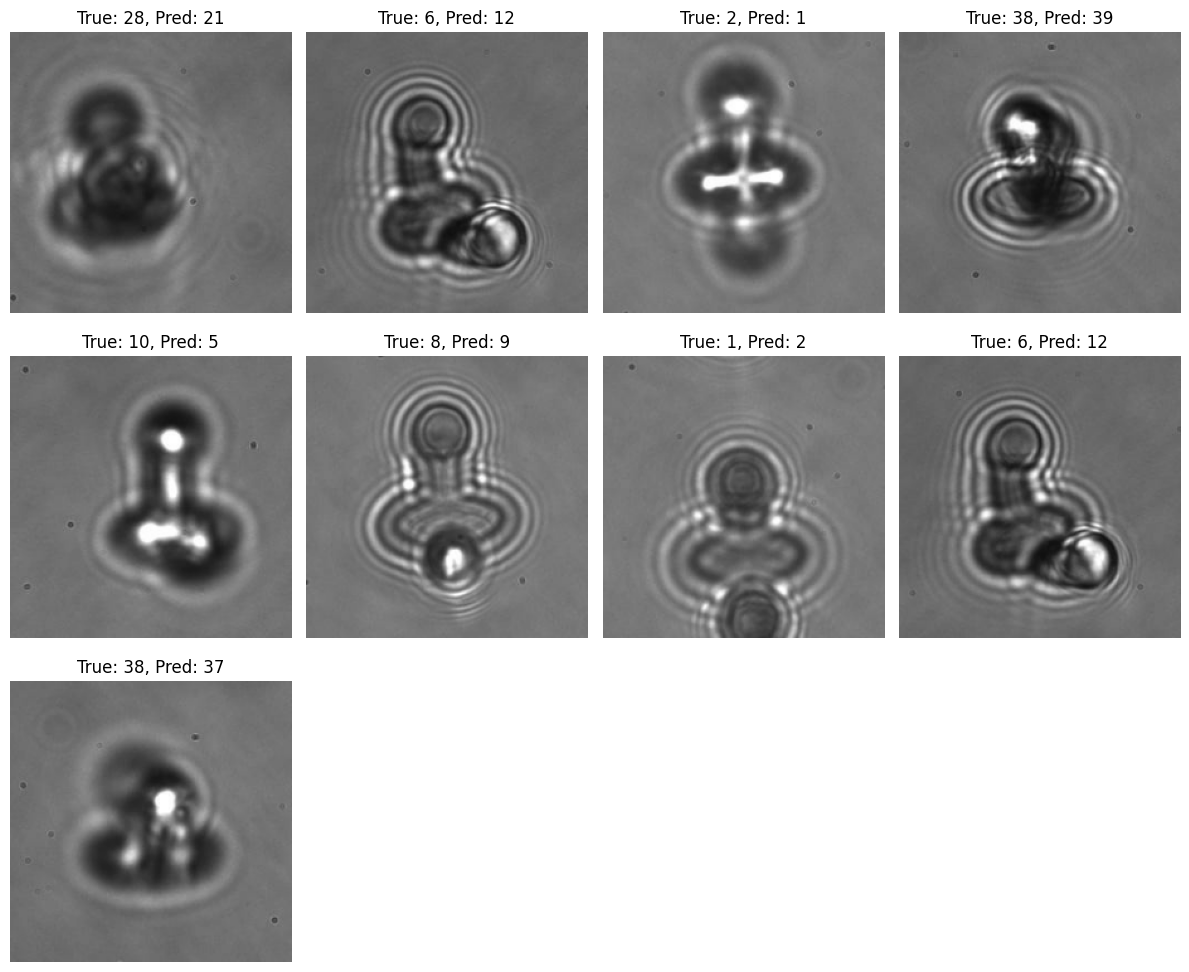

In [ ]:
# Inspect misclassified examples for the best optimised model

def get_misclassified_general(model, dataset):
    # Collect misclassified images and their true/predicted labels
    wrong_images = []
    wrong_true = []
    wrong_pred = []

    for images, labels in dataset:
        # Forward pass
        logits = model(images, training=False)
        preds = tf.argmax(logits, axis=1)

        # Handle one-hot or integer labels
        if len(labels.shape) > 1:
            true_class = tf.argmax(labels, axis=1)
        else:
            true_class = labels

        # Identify incorrect predictions
        mismatch = preds.numpy() != true_class.numpy()

        wrong_images.extend(images.numpy()[mismatch])
        wrong_true.extend(true_class.numpy()[mismatch])
        wrong_pred.extend(preds.numpy()[mismatch])

    return np.array(wrong_images), np.array(wrong_true), np.array(wrong_pred)


def show_errors(images, true_labels, pred_labels, n=12):
    # Display a grid of misclassified images
    plt.figure(figsize=(12, 10))

    for i in range(min(n, len(images))):
        plt.subplot(3, 4, i + 1)
        img = images[i]

        # Convert to uint8 for display if needed
        if img.max() <= 1.0:
            display_img = (img * 255).astype("uint8")
        else:
            display_img = img.astype("uint8")

        if len(display_img.shape) == 3 and display_img.shape[-1] == 1:
            display_img = display_img.squeeze()

        plt.imshow(display_img, cmap="gray")
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Select the best optimised model based on test accuracy
best_row = summary_df_opt.iloc[summary_df_opt["Test Accuracy"].idxmax()]
best_name = best_row["Model"]
print(f"Best optimised model by test accuracy: {best_name}")

# Match model and dataset based on model name
if "CNN" in best_name:
    best_model = cnn_opt
    best_dataset = test_ds
elif "ResNet" in best_name:
    best_model = resnet_opt
    best_dataset = test_ds_resnet
elif "VGG" in best_name:
    best_model = vgg_opt
    best_dataset = test_ds_vgg
else:
    raise ValueError("Could not match best model name")

# Extract misclassified samples
wrong_imgs, wrong_true, wrong_pred = get_misclassified_general(
    best_model, best_dataset
)

print("Total misclassified by best model:", len(wrong_imgs))

# Visualize a subset of errors
if len(wrong_imgs) > 0:
    show_errors(wrong_imgs, wrong_true, wrong_pred, n=12)
else:
    print("No misclassified images found for the best model.")

In [ ]:
# Dataset preparation for depth regression

def load_depth_sample(image_path, depth_value):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)

    return img, depth_value


def make_depth_ds(df, batch_size):
    # Extract image paths and normalized depth values
    paths = df["image_path"].astype(str).values
    depths = df["depth_norm"].astype("float32").values

    # Build tf.data pipeline
    ds = tf.data.Dataset.from_tensor_slices((paths, depths))
    ds = ds.map(load_depth_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds


# Batch size for training and evaluation
BATCH_SIZE = 32

train_ds_depth = make_depth_ds(train_df, BATCH_SIZE)
val_ds_depth   = make_depth_ds(val_df,   BATCH_SIZE)
test_ds_depth  = make_depth_ds(test_df,  BATCH_SIZE)

In [ ]:
# Image and training parameters
IMG_SIZE = 224
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32

# Compute depth normalization statistics from training set
depth_mean = train_df["depth"].mean()
depth_std  = train_df["depth"].std()

print("Depth mean (train):", depth_mean)
print("Depth std  (train):", depth_std)

# Normalize depth values across all splits
for df in [train_df, val_df, test_df]:
    df["depth_norm"] = (df["depth"] - depth_mean) / depth_std


def load_depth_sample(image_path, depth_value):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    return img, depth_value


def make_depth_ds(df, batch_size):
    # Build tf.data dataset for depth regression
    paths = df["image_path"].astype(str).values
    depths = df["depth_norm"].astype("float32").values

    ds = tf.data.Dataset.from_tensor_slices((paths, depths))
    ds = ds.map(load_depth_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds_depth = make_depth_ds(train_df, BATCH_SIZE)
val_ds_depth   = make_depth_ds(val_df,   BATCH_SIZE)
test_ds_depth  = make_depth_ds(test_df,  BATCH_SIZE)


def depth_resnet(input_shape=INPUT_SHAPE):
    # ResNet50 backbone for depth regression
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)

    # Apply ResNet preprocessing
    x = layers.Lambda(preprocess_input)(inputs)
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    # Predict normalized depth value
    outputs = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs, outputs, name="depth_resnet")
    return model, base_model


depth_model, base_model = depth_resnet()
depth_model.summary()


def rmse_norm(y_true, y_pred):
    # RMSE in normalized depth space
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


# Compile model with frozen backbone
depth_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae", rmse_norm],
)

callbacks = [
    EarlyStopping(
        monitor="val_mae",
        patience=5,
        restore_best_weights=True,
    ),
    ModelCheckpoint(
        "depth_resnet_initial.keras",
        monitor="val_mae",
        save_best_only=True,
    ),
]

initial_epochs = 20

history_depth = depth_model.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=initial_epochs,
    callbacks=callbacks,
    verbose=1,
)


# Fine-tune last ResNet layers
fine_tune_at = len(base_model.layers) - 30
print("Total ResNet layers:", len(base_model.layers))
print("Fine-tuning from layer index:", fine_tune_at)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

depth_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="mse",
    metrics=["mae", rmse_norm],
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_depth_ft = depth_model.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=total_epochs,
    initial_epoch=history_depth.epoch[-1],
    callbacks=callbacks,
    verbose=1,
)


# Final evaluation on test set
test_loss, test_mae, test_rmse = depth_model.evaluate(test_ds_depth, verbose=1)
print(f"\nTest MSE (norm) : {test_loss:.6f}")
print(f"Test MAE (norm) : {test_mae:.6f}")
print(f"Test RMSE (norm): {test_rmse:.6f}")

Depth mean (train): 0.4410708333333334
Depth std  (train): 0.3143773768820179


Model: "depth_resnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 391ms/step - loss: 18.6020 - mae: 3.0955 - rmse_norm: 3.3034 - val_loss: 0.3574 - val_mae: 0.4693 - val_rmse_norm: 0.5937
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.4491 - mae: 0.5359 - rmse_norm: 0.6637 - val_loss: 0.1766 - val_mae: 0.3358 - val_rmse_norm: 0.4160
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.2332 - mae: 0.3827 - rmse_norm: 0.4804 - val_loss: 0.1405 - val_mae: 0.2988 - val_rmse_norm: 0.3715
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.1713 - mae: 0.3247 - rmse_norm: 0.4084 - val_loss: 0.1181 - val_mae: 0.2701 - val_rmse_norm: 0.3406
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.1563 - mae: 0.2995 - rmse_norm: 0.3917 - val_loss: 0.1063 - val_mae: 0.2565 - val_rmse_norm: 0.3232
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.1316 - mae: 0.2789 - rmse_norm: 0.3586 - val_loss: 0.0969 - val_mae: 0.2436 - val_rmse_norm: 0.3083
Epoch 7/20
38/38 ━━━━━━━━━━━━━━

In [ ]:
# RMSE metric in normalized depth space
def rmse_norm(y_true, y_pred):
    # Flatten tensors to avoid shape mismatches
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Stage 1: frozen backbone, higher learning rate
depth_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[
        "mae",
        rmse_norm,
    ],
)

callbacks_stage1 = [
    EarlyStopping(monitor="val_mae", patience=5, restore_best_weights=True),
    ModelCheckpoint("depth_resnet_stage1.keras", monitor="val_mae", save_best_only=True),
]

print("Stage 1: Frozen ResNet backbone")
history_stage1 = depth_model.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=10,
    callbacks=callbacks_stage1,
    verbose=1,
)


# Stage 2: unfreeze last 30 ResNet layers
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

depth_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="mse",
    metrics=[
        "mae",
        rmse_norm,
    ],
)

callbacks_stage2 = [
    EarlyStopping(monitor="val_mae", patience=5, restore_best_weights=True),
    ModelCheckpoint("depth_resnet_stage2.keras", monitor="val_mae", save_best_only=True),
    ReduceLROnPlateau(
        monitor="val_mae",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
    ),
]

print("Stage 2: Fine-tune last 30 ResNet layers")
history_stage2 = depth_model.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=15,
    callbacks=callbacks_stage2,
    verbose=1,
)


# Stage 3: unfreeze entire ResNet backbone
for layer in base_model.layers:
    layer.trainable = True

depth_model.compile(
    optimizer=keras.optimizers.Adam(1e-6),
    loss="mse",
    metrics=[
        "mae",
        rmse_norm,
    ],
)

callbacks_stage3 = [
    EarlyStopping(monitor="val_mae", patience=5, restore_best_weights=True),
    ModelCheckpoint("depth_resnet_stage3.keras", monitor="val_mae", save_best_only=True),
    ReduceLROnPlateau(
        monitor="val_mae",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
    ),
]

print("Stage 3: Full-network fine-tuning")
history_stage3 = depth_model.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=10,
    callbacks=callbacks_stage3,
    verbose=1,
)

Stage 1: Frozen ResNet backbone
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 424ms/step - loss: 0.8892 - mae: 0.6251 - rmse_norm: 0.7550 - val_loss: 554.1055 - val_mae: 17.2574 - val_rmse_norm: 22.5740
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1597 - mae: 0.3156 - rmse_norm: 0.3941 - val_loss: 22.8947 - val_mae: 3.3718 - val_rmse_norm: 4.4816
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.1250 - mae: 0.2779 - rmse_norm: 0.3491 - val_loss: 6.8419 - val_mae: 1.5300 - val_rmse_norm: 2.4509
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.1152 - mae: 0.2710 - rmse_norm: 0.3341 - val_loss: 0.5546 - val_mae: 0.4584 - val_rmse_norm: 0.7031
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0636 - mae: 0.1958 - rmse_norm: 0.2477 - val_loss: 0.1034 - val_mae: 0.2523 - val_rmse_norm: 0.3162
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0658 - mae: 0.1980 - rmse_norm: 0.2521 - val_loss: 0.0902 - val_mae: 0.2339 - val_rmse_norm: 

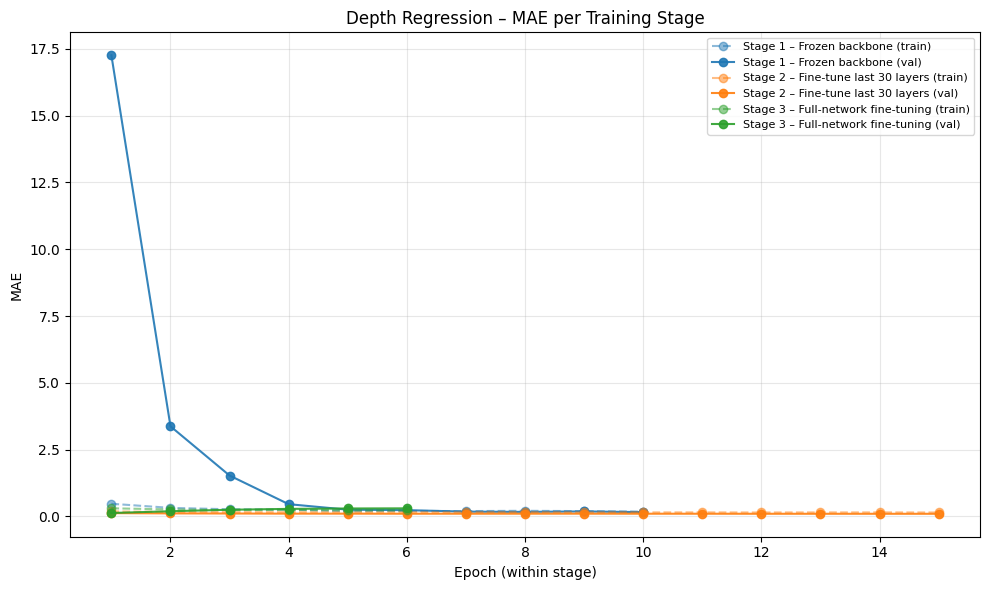

In [ ]:
def plot_mae_staged(histories, stage_labels, ylim=None):
    # Plot training and validation MAE for each fine-tuning stage
    plt.figure(figsize=(10, 6))
    colors = ["C0", "C1", "C2"]

    for h, label, color in zip(histories, stage_labels, colors):
        # Extract MAE curves for this stage
        train = np.array(h.history["mae"])
        val   = np.array(h.history["val_mae"])
        epochs = np.arange(1, len(train) + 1)

        # Training MAE
        plt.plot(
            epochs, train, "--o", alpha=0.5, color=color,
            label=f"{label} (train)"
        )

        # Validation MAE
        plt.plot(
            epochs, val, "-o", alpha=0.9, color=color,
            label=f"{label} (val)"
        )

    plt.xlabel("Epoch (within stage)")
    plt.ylabel("MAE")
    plt.title("Depth Regression – MAE per Training Stage")
    plt.grid(True, which="both", alpha=0.3)

    # Optional y-axis limits
    if ylim is not None:
        plt.ylim(*ylim)

    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()


# Plot MAE curves for the three progressive fine-tuning stages
histories = [history_stage1, history_stage2, history_stage3]

stage_labels = [
    "Stage 1 – Frozen backbone",
    "Stage 2 – Fine-tune last 30 layers",
    "Stage 3 – Full-network fine-tuning",
]

plot_mae_staged(histories, stage_labels)

In [ ]:
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH  = IMG_SIZE

def depth_cnn_pose_style(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    # CNN architecture matching the pose-classification CNN style
    inputs = keras.Input(shape=input_shape, name="depth_input_image")

    # Identity rescaling
    x = layers.Rescaling(1.0)(inputs)

    # Conv block 1: 224 -> 112
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Conv block 2: 112 -> 56
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Conv block 3: 56 -> 28
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Conv block 4: 28 -> 14
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Conv block 5: 14 -> 7
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Flatten spatial features
    x = layers.Flatten()(x)

    # Dense regression head
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Predict normalized depth value
    outputs = layers.Dense(1, activation="linear", name="depth_norm")(x)

    model = keras.Model(inputs, outputs, name="depth_cnn_pose_style")
    return model


tf.keras.backend.clear_session()
depth_cnn = depth_cnn_pose_style()
depth_cnn.summary()

# Sanity check: dataset batch shape
for xb, yb in train_ds_depth.take(1):
    print("train_ds_depth batch:", xb.shape, xb.dtype)
    break



def rmse_norm(y_true, y_pred):
    # RMSE in normalized depth space
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


# Compile depth CNN (stage 1)
depth_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss="mse",
    metrics=[
        "mae",
        rmse_norm,
    ],
)

callbacks_depth_cnn = [
    EarlyStopping(
        monitor="val_mae",
        patience=5,
        restore_best_weights=True,
    ),
    ModelCheckpoint(
        "depth_cnn_pose_style_best.keras",
        monitor="val_mae",
        save_best_only=True,
    ),
]

epochs_depth_cnn = 20

history_depth_cnn = depth_cnn.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=epochs_depth_cnn,
    callbacks=callbacks_depth_cnn,
    verbose=1,
)


# Stage 2: fine-tuning with reduced learning rate
from keras.callbacks import ReduceLROnPlateau

depth_cnn.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=[
        "mae",
        rmse_norm,
    ],
)

callbacks_depth_cnn_stage2 = [
    EarlyStopping(
        monitor="val_mae",
        patience=5,
        restore_best_weights=True,
    ),
    ModelCheckpoint(
        "depth_cnn_pose_style_stage2.keras",
        monitor="val_mae",
        save_best_only=True,
    ),
    ReduceLROnPlateau(
        monitor="val_mae",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
    ),
]

epochs_depth_cnn_stage2 = 20

print("Depth CNN – Stage 2: fine-tuning with LR scheduling")
history_depth_cnn_stage2 = depth_cnn.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=epochs_depth_cnn_stage2,
    callbacks=callbacks_depth_cnn_stage2,
    verbose=1,
)


# Final evaluation on test set
test_loss_cnn, test_mae_cnn, test_rmse_cnn = depth_cnn.evaluate(
    test_ds_depth, verbose=1
)

print(f"[Depth CNN – advanced] Test MSE (norm):  {test_loss_cnn:.6f}")
print(f"[Depth CNN – advanced] Test MAE (norm):  {test_mae_cnn:.6f}")
print(f"[Depth CNN – advanced] Test RMSE (norm): {test_rmse_cnn:.6f}")


Model: "depth_cnn_pose_style"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ depth_input_image (InputLayer)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depth_norm (Dense)              │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,190,273 (15.98 MB)

 Trainable params: 4,190,273 (15.98 MB)

 Non-trainable params: 0 (0.00 B)

train_ds_depth batch: (32, 224, 224, 3) <dtype: 'float32'>
Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - loss: 1340.9773 - mae: 15.1579 - rmse_norm: 15.9173 - val_loss: 0.8050 - val_mae: 0.7773 - val_rmse_norm: 0.8890
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.7678 - mae: 0.7568 - rmse_norm: 0.8689 - val_loss: 0.4149 - val_mae: 0.5750 - val_rmse_norm: 0.6399
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.5069 - mae: 0.5797 - rmse_norm: 0.7079 - val_loss: 0.2953 - val_mae: 0.4376 - val_rmse_norm: 0.5402
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.4254 - mae: 0.5285 - rmse_norm: 0.6484 - val_loss: 0.2043 - val_mae: 0.3642 - val_rmse_norm: 0.4494
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.3764 - mae: 0.4941 - rmse_norm: 0.6077 - val_loss: 0.1840 - val_mae: 0.3510 - val_rmse_norm: 0.4266
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.3096 - mae: 0.4502 - rmse_norm: 0.5519 - val_loss: 0.1602 - val_mae:

In [ ]:
# VGG16-based depth regressor

def vgg16_depth_regressor(input_shape, name="depth_regressor_vgg16"):
    # VGG16 backbone with a small regression head
    inputs = keras.Input(shape=input_shape)

    # Identity scaling
    x = layers.Rescaling(1.0 / 255.0)(inputs)

    # VGG16 feature extractor
    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    base_model.trainable = False

    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    # Regression head
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs, outputs, name=name)
    return model


# Build and inspect the model
depth_model_vgg = vgg16_depth_regressor(INPUT_SHAPE)
depth_model_vgg.summary()


def rmse_norm(y_true, y_pred):
    # RMSE in normalized depth space
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


# Compile for initial training, frozen backbone
depth_model_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[
        "mae",
        rmse_norm,
    ],
)

callbacks_vgg_stage1 = [
    EarlyStopping(
        monitor="val_mae",
        patience=5,
        restore_best_weights=True,
    ),
    ModelCheckpoint(
        "depth_vgg16_stage1.keras",
        monitor="val_mae",
        save_best_only=True,
    ),
]

initial_epochs = 10

# Stage 1: train regression head with frozen VGG16
history_vgg_stage1 = depth_model_vgg.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=initial_epochs,
    callbacks=callbacks_vgg_stage1,
    verbose=1,
)


# Stage 2: fine-tune top VGG16 layers

# Locate the VGG16 backbone inside the model
base_model_vgg = None
for layer in depth_model_vgg.layers:
    if isinstance(layer, keras.Model) and layer.name.startswith("vgg16"):
        base_model_vgg = layer
        break

if base_model_vgg is None:
    raise RuntimeError("Could not locate VGG16 backbone inside depth_model_vgg.")

# Unfreeze last N VGG16 layers
fine_tune_at = len(base_model_vgg.layers) - 8

for layer in base_model_vgg.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model_vgg.layers[fine_tune_at:]:
    layer.trainable = True

print(
    f"Unfreezing VGG16 from layer {fine_tune_at} / "
    f"{len(base_model_vgg.layers)} for fine-tuning"
)

# Recompile with smaller learning rate
depth_model_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="mse",
    metrics=[
        "mae",
        rmse_norm,
    ],
)

callbacks_vgg_stage2 = [
    EarlyStopping(
        monitor="val_mae",
        patience=5,
        restore_best_weights=True,
    ),
    ModelCheckpoint(
        "depth_vgg16_stage2.keras",
        monitor="val_mae",
        save_best_only=True,
    ),
]

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_vgg_stage2 = depth_model_vgg.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=total_epochs,
    initial_epoch=history_vgg_stage1.epoch[-1],
    callbacks=callbacks_vgg_stage2,
    verbose=1,
)


# Stage 3: full-network fine-tuning

for layer in base_model_vgg.layers:
    layer.trainable = True

depth_model_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-6),
    loss="mse",
    metrics=[
        "mae",
        rmse_norm,
    ],
)

callbacks_vgg_stage3 = [
    EarlyStopping(
        monitor="val_mae",
        patience=5,
        restore_best_weights=True,
    ),
    ModelCheckpoint(
        "depth_vgg16_stage3.keras",
        monitor="val_mae",
        save_best_only=True,
    ),
    ReduceLROnPlateau(
        monitor="val_mae",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
    ),
]

fine_tune_epochs_stage3 = 10
total_epochs_stage3 = total_epochs + fine_tune_epochs_stage3

print("Stage 3: Full-network fine-tuning (all VGG16 layers trainable)")
history_vgg_stage3 = depth_model_vgg.fit(
    train_ds_depth,
    validation_data=val_ds_depth,
    epochs=total_epochs_stage3,
    initial_epoch=history_vgg_stage2.epoch[-1],
    callbacks=callbacks_vgg_stage3,
    verbose=1,
)


# Final evaluation on test set
test_loss_vgg, test_mae_norm_vgg, test_rmse_norm_vgg = depth_model_vgg.evaluate(
    test_ds_depth, verbose=1
)

print(f"[VGG16 Depth – advanced] Test MSE (norm):  {test_loss_vgg:.6f}")
print(f"[VGG16 Depth – advanced] Test MAE (norm):  {test_mae_norm_vgg:.6f}")
print(f"[VGG16 Depth – advanced] Test RMSE (norm): {test_rmse_norm_vgg:.6f}")

Model: "depth_regressor_vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.9143 - mae: 0.7670 - rmse_norm: 0.9414 - val_loss: 0.2767 - val_mae: 0.4334 - val_rmse_norm: 0.5237
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.3796 - mae: 0.5068 - rmse_norm: 0.6133 - val_loss: 0.2127 - val_mae: 0.3751 - val_rmse_norm: 0.4584
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.2654 - mae: 0.4141 - rmse_norm: 0.5123 - val_loss: 0.1868 - val_mae: 0.3535 - val_rmse_norm: 0.4294
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.2398 - mae: 0.3849 - rmse_norm: 0.4851 - val_loss: 0.1577 - val_mae: 0.3115 - val_rmse_norm: 0.3937
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.2150 - mae: 0.3665 - rmse_norm: 0.4586 - val_loss: 0.1369 - val_mae: 0.2900 - val_rmse_norm: 0.3664
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1935 - mae: 0.3437 - rmse_norm: 0.4357 - val_loss: 0.1306 - val_mae: 0.2880 - val_rmse_norm: 0.3586
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━

Loaded ResNet50 - Stage 1
Loaded ResNet50 - Stage 2
Loaded ResNet50 - Stage 3
Loaded VGG16 - Stage 1
Loaded VGG16 - Stage 2

===== FINAL DEPTH REGRESSION RESULTS =====
                Model  Test RMSE  Test MAE  R² Score  Val RMSE
0            ResNet50   0.053546  0.041177  0.970448  0.053427
1          Simple CNN   0.060006  0.045016  0.962888  0.057637
2               VGG16   0.045783  0.033138  0.978395  0.044617
3  ResNet50 - Stage 1   0.063615  0.049696  0.958288  0.064891
4  ResNet50 - Stage 2   0.042768  0.030888  0.981147  0.042008
5  ResNet50 - Stage 3   0.053546  0.041177  0.970448  0.053427
6     VGG16 - Stage 1   0.109391  0.080819  0.876662  0.100089
7     VGG16 - Stage 2   0.058673  0.044613  0.964518  0.056489


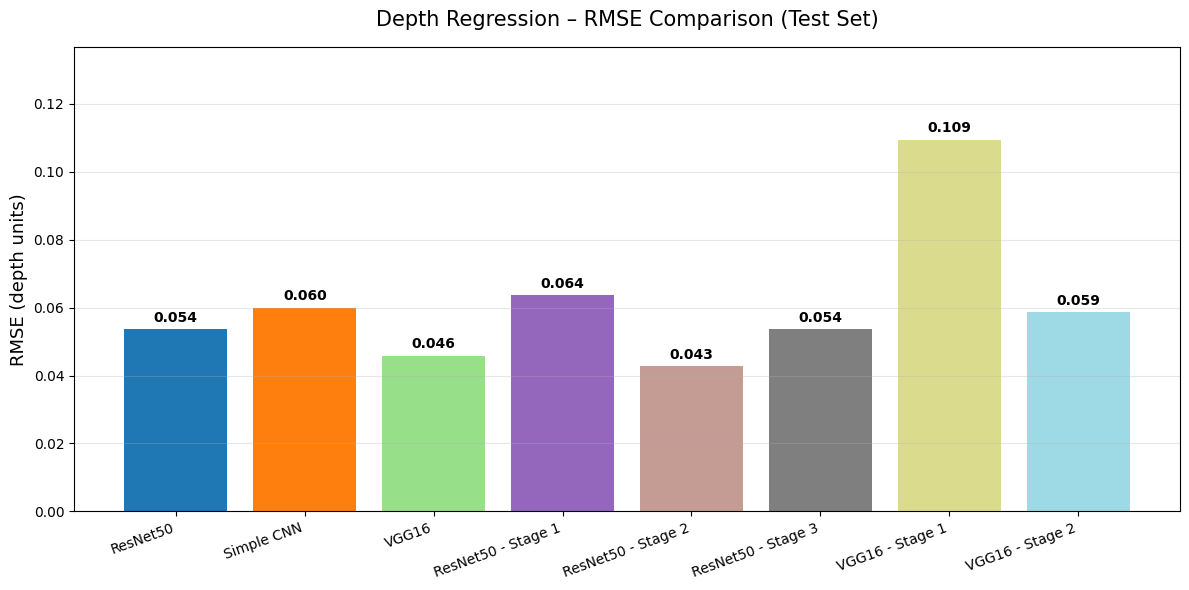

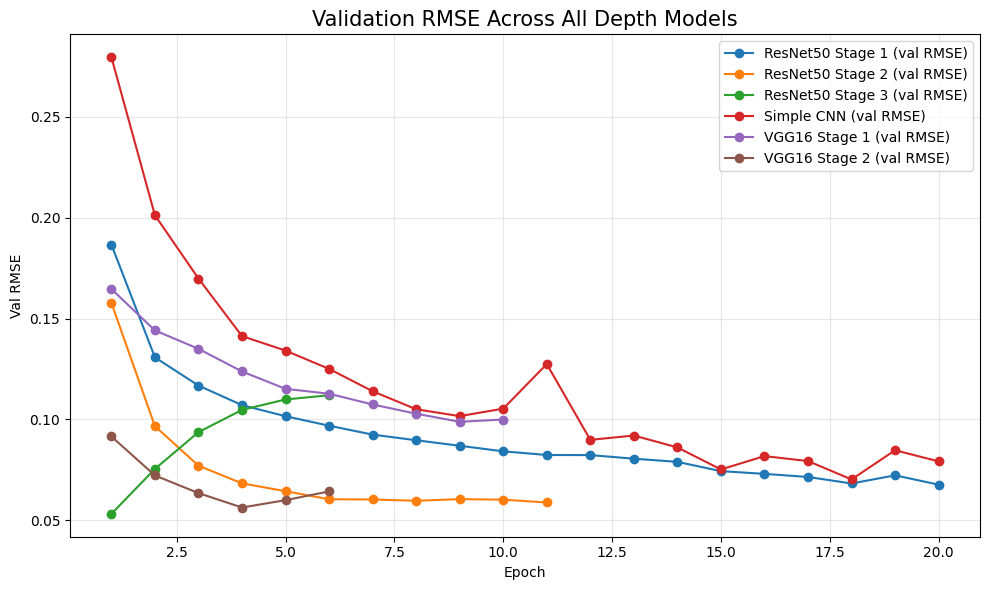

In [ ]:
# Depth regression evaluation across all trained models

def compute_depth_metrics(model, dataset, depth_mean, depth_std):
    # Compute RMSE, MAE, and R²
    y_true_list = []
    y_pred_list = []

    for batch_imgs, batch_depth_norm in dataset:
        preds_norm = model(batch_imgs, training=False).numpy().reshape(-1)
        true_norm  = batch_depth_norm.numpy().reshape(-1)

        # Convert normalized depth back to original scale
        preds = preds_norm * depth_std + depth_mean
        true  = true_norm  * depth_std + depth_mean

        y_true_list.append(true)
        y_pred_list.append(preds)

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae  = np.mean(np.abs(y_true - y_pred))
    r2   = r2_score(y_true, y_pred)

    return rmse, mae, r2


model_entries = [
    ("ResNet50", depth_model),
    ("Simple CNN", depth_cnn),
    ("VGG16", depth_model_vgg),
]


# Paths to saved stage checkpoints
stage_paths = [
    ("ResNet50 - Stage 1", "depth_resnet_stage1.keras", "resnet"),
    ("ResNet50 - Stage 2", "depth_resnet_stage2.keras", "resnet"),
    ("ResNet50 - Stage 3", "depth_resnet_stage3.keras", "resnet"),
    ("VGG16 - Stage 1", "depth_vgg16_stage1.keras", "vgg"),
    ("VGG16 - Stage 2", "depth_vgg16_stage2.keras", "vgg"),
]

for name, path, arch in stage_paths:
    try:
        if arch == "resnet":
            loaded_model = keras.models.load_model(
                path,
                custom_objects={
                    "preprocess_input": preprocess_input,
                    "rmse_norm": rmse_norm,
                },
                compile=False,
            )
        else:
            loaded_model = keras.models.load_model(
                path,
                custom_objects={"rmse_norm": rmse_norm},
                compile=False,
            )

        model_entries.append((name, loaded_model))
        print(f"Loaded {name}")

    except OSError:
        print(f"Missing checkpoint: {path} (skipped)")


# Compute test and validation metrics for all models
results = []

for name, model in model_entries:
    # Metrics on test set
    rmse_test, mae_test, r2 = compute_depth_metrics(
        model, test_ds_depth, depth_mean, depth_std
    )

    # Validation RMSE only
    rmse_val, _, _ = compute_depth_metrics(
        model, val_ds_depth, depth_mean, depth_std
    )

    results.append([name, rmse_test, mae_test, r2, rmse_val])

results_df = pd.DataFrame(
    results, columns=["Model", "Test RMSE", "Test MAE", "R² Score", "Val RMSE"]
)

print("\n===== FINAL DEPTH REGRESSION RESULTS =====")
print(results_df)


# Bar plot: test RMSE comparison
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(results_df)))

bars = plt.bar(results_df["Model"], results_df["Test RMSE"], color=colors)

plt.ylabel("RMSE (depth units)", fontsize=13)
plt.title("Depth Regression – RMSE Comparison (Test Set)", fontsize=15, pad=15)
plt.grid(axis="y", alpha=0.3)

y_max = results_df["Test RMSE"].max()
plt.ylim(0, y_max * 1.25)

# Annotate bars with RMSE values
for bar, val in zip(bars, results_df["Test RMSE"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + (0.02 * y_max),
        f"{val:.3f}",
        ha="center",
        fontsize=10,
        fontweight="bold"
    )

plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


def add_rmse_curve(history, label, depth_std):
    # Plot validation RMSE curve
    if history is None or not hasattr(history, "history"):
        return

    if "val_rmse_norm" in history.history:
        rmse_vals_norm = np.array(history.history["val_rmse_norm"])
        rmse_vals = rmse_vals_norm * depth_std
        epochs = range(1, len(rmse_vals) + 1)
        plt.plot(epochs, rmse_vals, marker="o", label=label)


# Validation RMSE curves across models and stages
plt.figure(figsize=(10, 6))

add_rmse_curve(history_depth,    "ResNet50 Stage 1 (val RMSE)", depth_std)
add_rmse_curve(history_depth_ft, "ResNet50 Stage 2 (val RMSE)", depth_std)
add_rmse_curve(
    history_stage3 if "history_stage3" in globals() else None,
    "ResNet50 Stage 3 (val RMSE)",
    depth_std,
)

add_rmse_curve(history_depth_cnn, "Simple CNN (val RMSE)", depth_std)

add_rmse_curve(history_vgg_stage1, "VGG16 Stage 1 (val RMSE)", depth_std)
add_rmse_curve(history_vgg_stage2, "VGG16 Stage 2 (val RMSE)", depth_std)

plt.title("Validation RMSE Across All Depth Models", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Val RMSE")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Loaded ResNet50 - Stage 1
Loaded ResNet50 - Stage 2
Loaded ResNet50 - Stage 3
Loaded VGG16 - Stage 1
Loaded VGG16 - Stage 2

=== Collecting validation predictions for: ResNet50 ===

=== Collecting validation predictions for: Simple CNN ===

=== Collecting validation predictions for: VGG16 ===

=== Collecting validation predictions for: ResNet50 - Stage 1 ===

=== Collecting validation predictions for: ResNet50 - Stage 2 ===

=== Collecting validation predictions for: ResNet50 - Stage 3 ===

=== Collecting validation predictions for: VGG16 - Stage 1 ===

=== Collecting validation predictions for: VGG16 - Stage 2 ===

Depth Regression – Validation Set Metrics
             Model  Val RMSE  Val MAE
          ResNet50  0.053427 0.040372
        Simple CNN  0.057637 0.043158
             VGG16  0.044617 0.032909
ResNet50 - Stage 1  0.064891 0.050420
ResNet50 - Stage 2  0.042008 0.030858
ResNet50 - Stage 3  0.053427 0.040372
   VGG16 - Stage 1  0.100089 0.077981
   VGG16 - Stage 2  0.056489 0

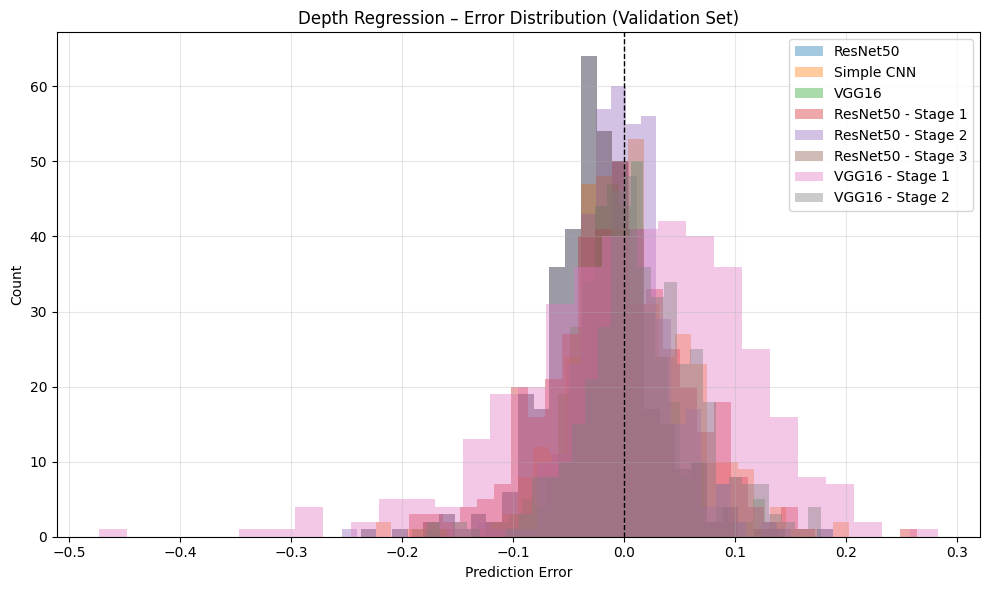

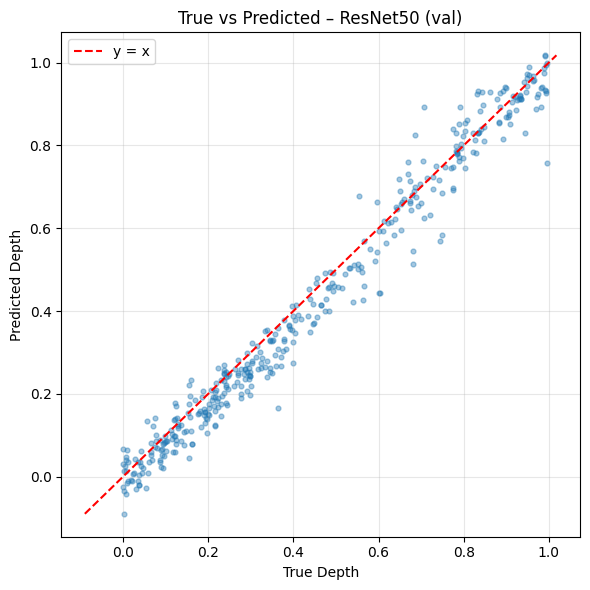

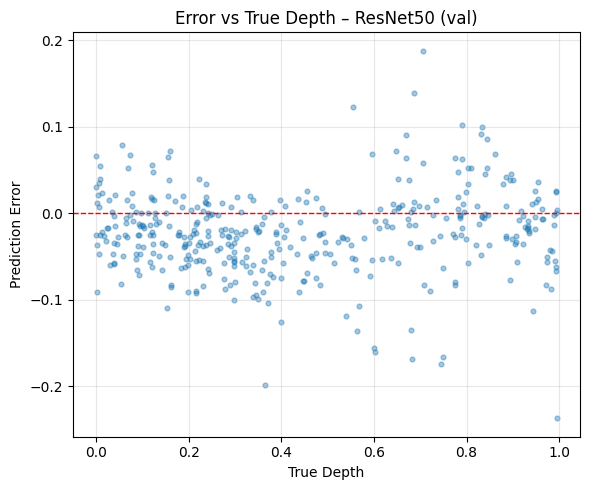

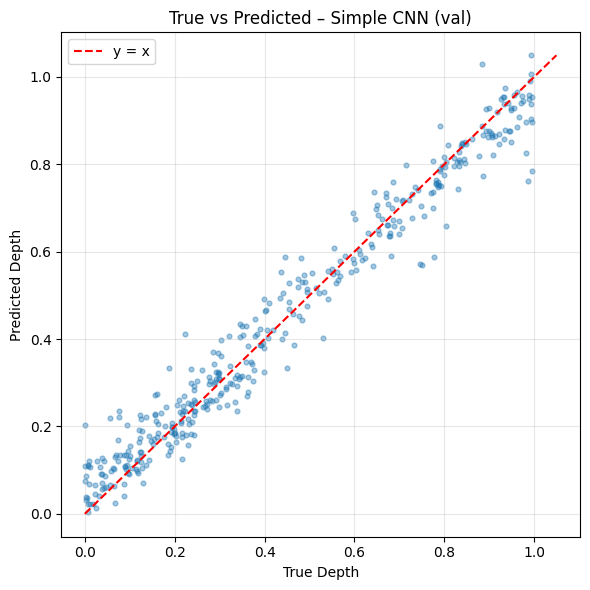

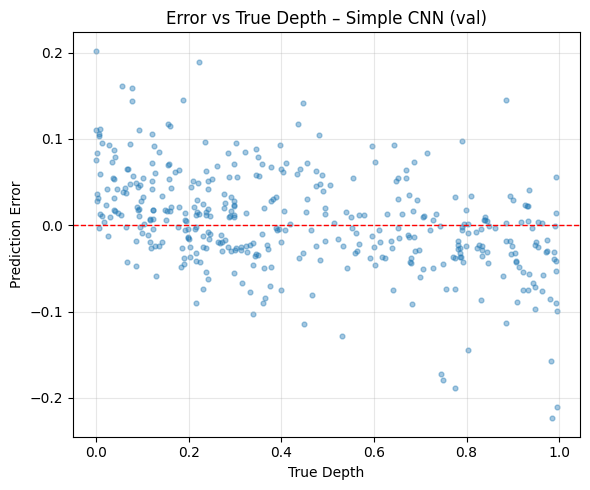

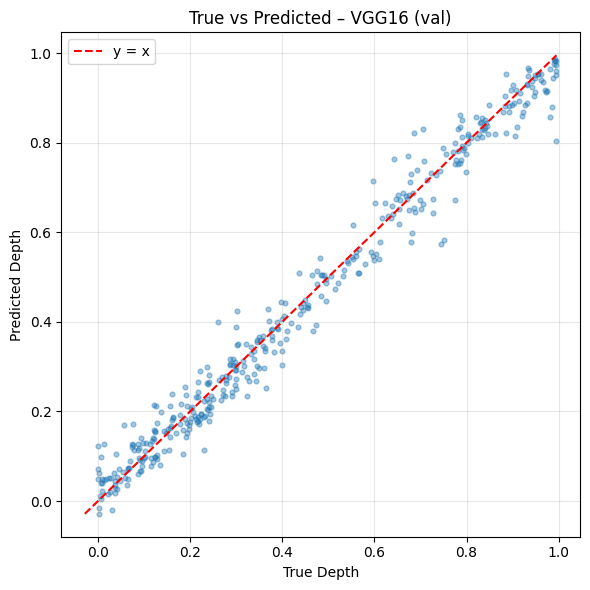

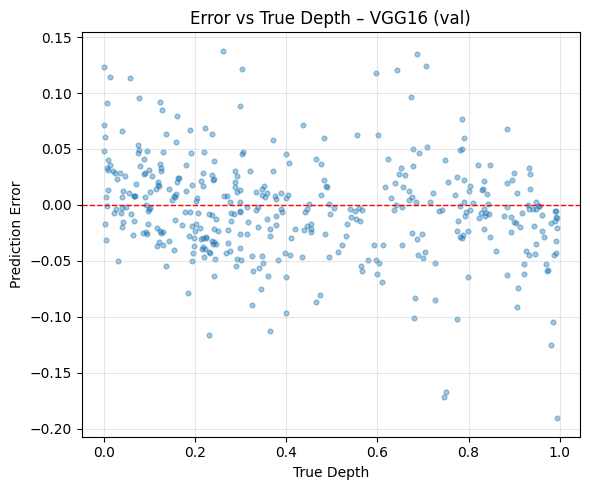

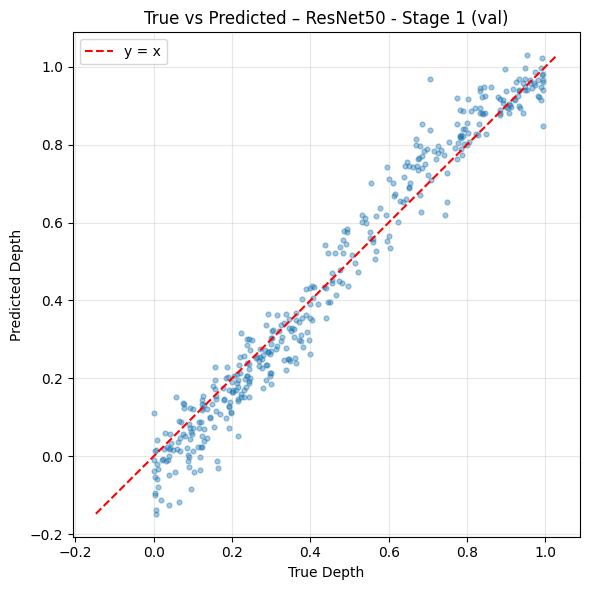

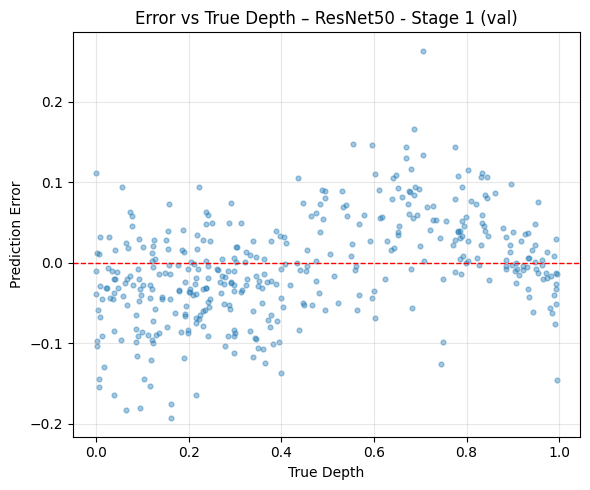

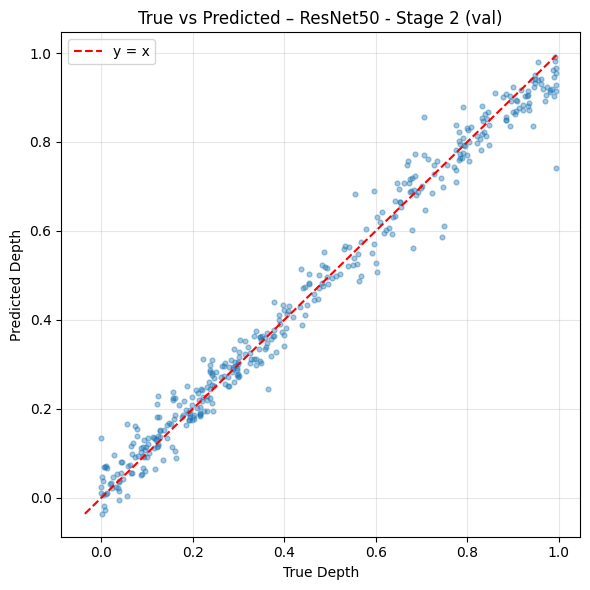

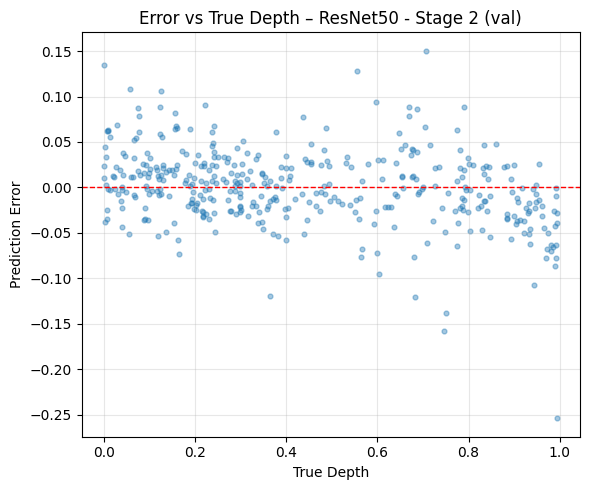

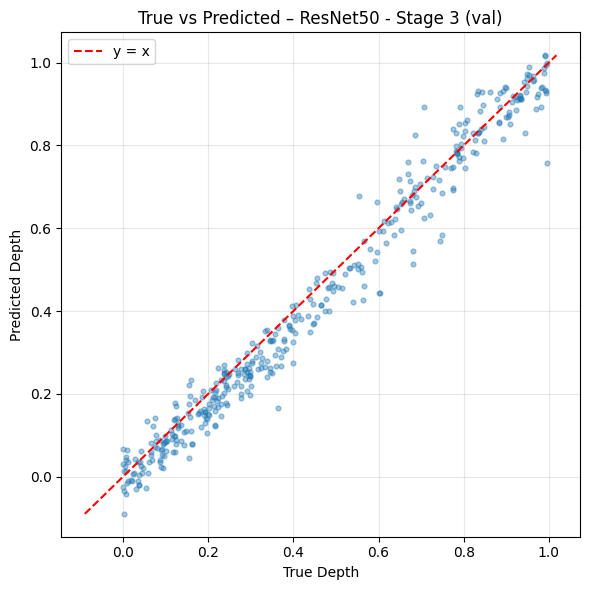

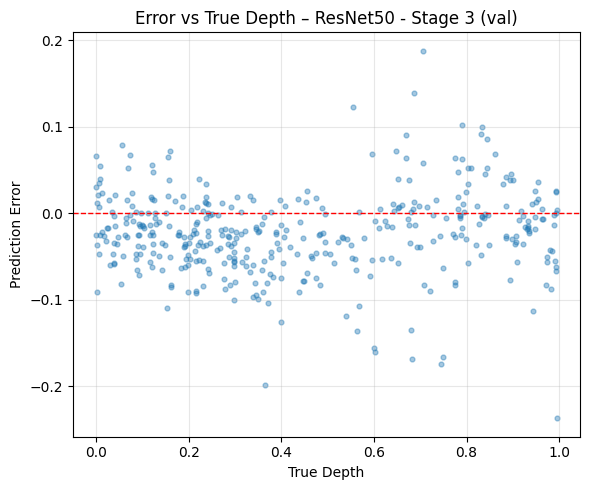

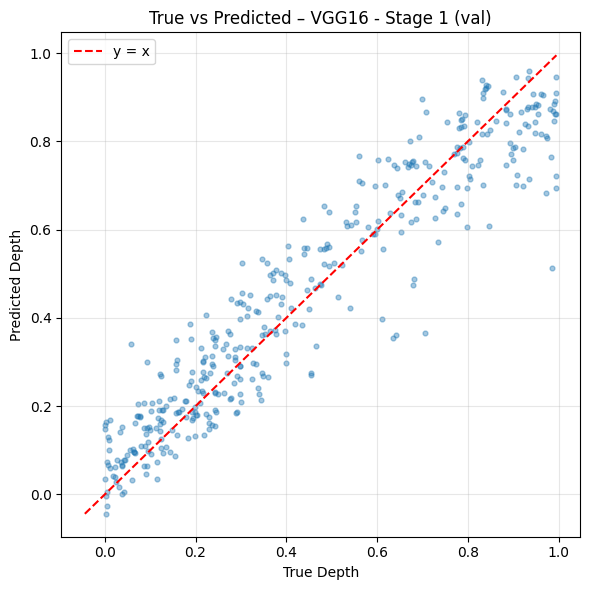

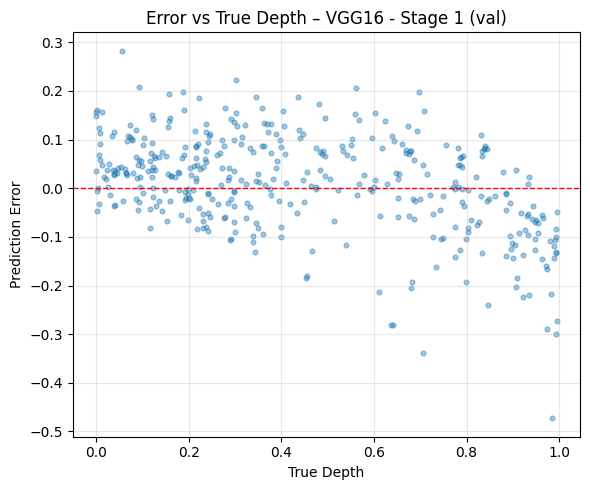

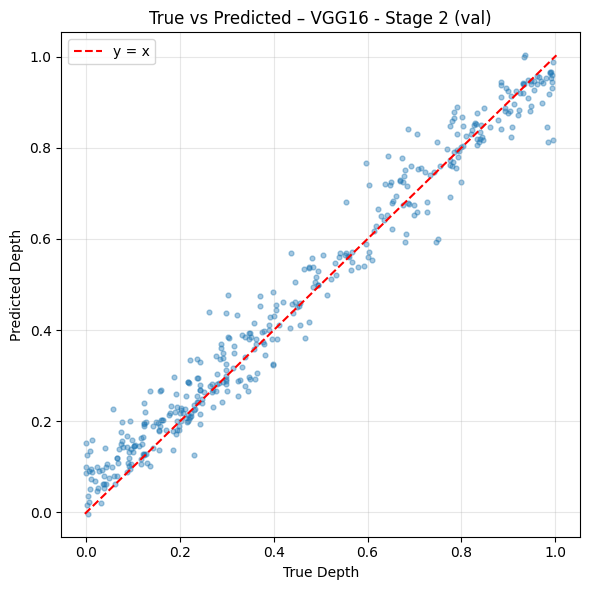

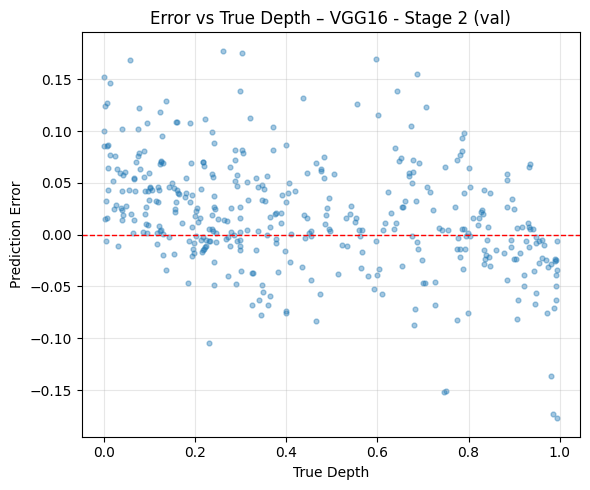

In [ ]:
# Depth regression error analysis on the validation set


def rmse_norm(y_true, y_pred):
    # RMSE in normalized depth space
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


def collect_depth_predictions(model, dataset, depth_mean, depth_std):
    # Collect true depths, predictions, and errors in true depth units
    y_true_list = []
    y_pred_list = []

    for batch_imgs, batch_depth_norm in dataset:
        preds_norm = model(batch_imgs, training=False).numpy().reshape(-1)
        true_norm  = batch_depth_norm.numpy().reshape(-1)

        # Convert normalized depth back to original scale
        preds = preds_norm * depth_std + depth_mean
        true  = true_norm  * depth_std + depth_mean

        y_true_list.append(true)
        y_pred_list.append(preds)

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    errors = y_pred - y_true

    return y_true, y_pred, errors


def compute_metrics_from_arrays(y_true, y_pred):
    # Compute RMSE and MAE
    diff = y_true - y_pred
    rmse = np.sqrt(np.mean(diff ** 2))
    mae  = np.mean(np.abs(diff))
    return rmse, mae


def plot_error_histogram_per_model(errors_dict, bins=30):
    # Plot error distribution for all models
    plt.figure(figsize=(10, 6))

    for name, err in errors_dict.items():
        plt.hist(err, bins=bins, alpha=0.4, label=name)

    plt.axvline(0.0, color="k", linestyle="--", linewidth=1)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.title("Depth Regression – Error Distribution (Validation Set)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_true_vs_pred_scatter(y_true, y_pred, model_name):
    # Scatter plot of true depth vs predicted depth
    plt.figure(figsize=(6, 6))

    plt.scatter(y_true, y_pred, alpha=0.4, s=12)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())

    plt.plot([min_val, max_val], [min_val, max_val], "r--", label="y = x")

    plt.xlabel("True Depth")
    plt.ylabel("Predicted Depth")
    plt.title(f"True vs Predicted – {model_name} (val)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_error_vs_true(y_true, errors, model_name):
    # Error vs true depth to reveal depth-dependent bias
    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, errors, alpha=0.4, s=12)

    plt.axhline(0.0, color="r", linestyle="--", linewidth=1)
    plt.xlabel("True Depth")
    plt.ylabel("Prediction Error")
    plt.title(f"Error vs True Depth – {model_name} (val)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


model_entries = [
    ("ResNet50",   depth_model),
    ("Simple CNN", depth_cnn),
    ("VGG16",      depth_model_vgg),
]


# Paths to saved stage checkpoints
stage_paths = [
    ("ResNet50 - Stage 1", "depth_resnet_stage1.keras", "resnet"),
    ("ResNet50 - Stage 2", "depth_resnet_stage2.keras", "resnet"),
    ("ResNet50 - Stage 3", "depth_resnet_stage3.keras", "resnet"),
    ("VGG16 - Stage 1",    "depth_vgg16_stage1.keras",  "vgg"),
    ("VGG16 - Stage 2",    "depth_vgg16_stage2.keras",  "vgg"),
]

# Load additional trained models
for name, path, arch in stage_paths:
    try:
        if arch == "resnet":
            loaded_model = keras.models.load_model(
                path,
                custom_objects={
                    "preprocess_input": preprocess_input,
                    "rmse_norm": rmse_norm,
                },
                compile=False,
            )
        else:
            loaded_model = keras.models.load_model(
                path,
                custom_objects={"rmse_norm": rmse_norm},
                compile=False,
            )

        model_entries.append((name, loaded_model))
        print(f"Loaded {name}")

    except OSError:
        print(f"Missing checkpoint: {path} (skipped)")


# Run validation analysis for all models
results_rows = []
errors_dict = {}
y_true_dict = {}
y_pred_dict = {}

for name, model in model_entries:
    print(f"\n=== Collecting validation predictions for: {name} ===")

    y_true, y_pred, errors = collect_depth_predictions(
        model, val_ds_depth, depth_mean, depth_std
    )

    errors_dict[name] = errors
    y_true_dict[name] = y_true
    y_pred_dict[name] = y_pred

    rmse, mae = compute_metrics_from_arrays(y_true, y_pred)
    results_rows.append([name, rmse, mae])


# Validation metrics table
results_df = pd.DataFrame(
    results_rows,
    columns=["Model", "Val RMSE", "Val MAE"],
)

print("\nDepth Regression – Validation Set Metrics")
print(results_df.to_string(index=False))


# Compare error distributions across models
plot_error_histogram_per_model(errors_dict, bins=30)


# Per-model scatter and error plots
for name in errors_dict.keys():
    y_true = y_true_dict[name]
    y_pred = y_pred_dict[name]
    errors = errors_dict[name]

    plot_true_vs_pred_scatter(y_true, y_pred, model_name=name)
    plot_error_vs_true(y_true, errors, model_name=name)



Hyperparameter search – ResNet50 Stage-2 depth model

=== Run: lr=1e-05, dropout=0.3, fine_tune_layers=30 ===
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - loss: 0.9647 - mae: 0.7727 - rmse_norm: 0.9548 - val_loss: 0.6402 - val_mae: 0.6374 - val_rmse_norm: 0.8006 - learning_rate: 1.0000e-05
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.3542 - mae: 0.4713 - rmse_norm: 0.5902 - val_loss: 0.4424 - val_mae: 0.5256 - val_rmse_norm: 0.6639 - learning_rate: 1.0000e-05
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.2943 - mae: 0.4339 - rmse_norm: 0.5389 - val_loss: 0.2510 - val_mae: 0.3962 - val_rmse_norm: 0.5005 - learning_rate: 1.0000e-05
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.2493 - mae: 0.3947 - rmse_norm: 0.4959 - val_loss: 0.2041 - val_mae: 0.3606 - val_rmse_norm: 0.4503 - learning_rate: 1.0000e-05
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.2186 - mae: 0.3690 - rmse_norm: 0.4634 - val_loss: 0.1310 - val_mae: 0

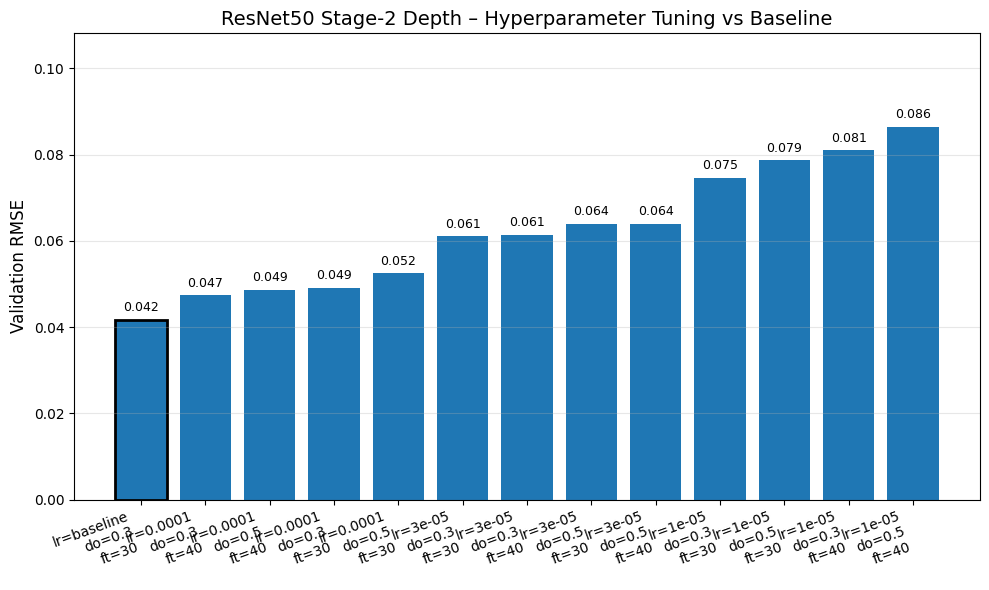

In [ ]:
# Hyperparameter Tuning
# ResNet50 Stage-2 depth model

def rmse_norm(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Build ResNet50 with hyperparameters

def depth_resnet_hp(input_shape, dropout_rate, fine_tune_layers):

    base_model = keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )

    base_model.trainable = False

    inputs = keras.Input(shape=input_shape, name="depth_resnet_input")
    x = layers.Lambda(preprocess_input)(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs, outputs, name="depth_resnet_hp")

    # Unfreeze last N layers
    total_layers = len(base_model.layers)
    fine_tune_at = max(0, total_layers - fine_tune_layers)

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    return model


# Hyperparameter grid

learning_rates = [1e-5, 3e-5, 1e-4]
dropout_rates  = [0.3, 0.5]
fine_tune_list = [30, 40]

results_hp = []

print("\nHyperparameter search – ResNet50 Stage-2 depth model\n")


# Run hyperparameter search

for lr in learning_rates:
    for dr in dropout_rates:
        for ft in fine_tune_list:

            print(f"=== Run: lr={lr}, dropout={dr}, fine_tune_layers={ft} ===")

            tf.keras.backend.clear_session()

            model = depth_resnet_hp(INPUT_SHAPE, dr, ft)

            model.compile(
                optimizer=keras.optimizers.Adam(lr),
                loss="mse",
                metrics=["mae", rmse_norm],
            )

            callbacks = [
                EarlyStopping(
                    monitor="val_rmse_norm",
                    mode="min",
                    patience=4,
                    restore_best_weights=True,
                ),
                ReduceLROnPlateau(
                    monitor="val_rmse_norm",
                    factor=0.5,
                    patience=2,
                    min_lr=1e-7,
                ),
            ]

            history = model.fit(
                train_ds_depth,
                validation_data=val_ds_depth,
                epochs=15,
                callbacks=callbacks,
                verbose=1,
            )

            val_rmse = np.array(history.history["val_rmse_norm"])
            val_mae  = np.array(history.history["val_mae"])

            best_idx = np.argmin(val_rmse)

            best_val_rmse_norm = val_rmse[best_idx]
            best_val_mae_norm  = val_mae[best_idx]

            best_val_rmse_real = best_val_rmse_norm * depth_std
            best_val_mae_real  = best_val_mae_norm  * depth_std

            results_hp.append({
                "learning_rate": lr,
                "dropout": dr,
                "fine_tune_layers": ft,
                "best_val_RMSE_real": best_val_rmse_real,
                "best_val_MAE_real": best_val_mae_real,
            })



# Evaluate original Stage-2 baseline

print("\nEvaluating original Stage-2 baseline...")

stage2_model = keras.models.load_model(
    "depth_resnet_stage2.keras",
    custom_objects={
        "preprocess_input": preprocess_input,
        "rmse_norm": rmse_norm,
    },
    compile=False,
)

stage2_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="mse",
    metrics=["mae", rmse_norm],
)

_, val_mae_norm, val_rmse_norm = stage2_model.evaluate(
    val_ds_depth, verbose=0
)

results_hp.append({
    "learning_rate": "baseline",
    "dropout": 0.3,
    "fine_tune_layers": 30,
    "best_val_RMSE_real": val_rmse_norm * depth_std,
    "best_val_MAE_real": val_mae_norm  * depth_std,
})



# Results table

results_hp_df = pd.DataFrame(results_hp)
results_hp_df = results_hp_df.sort_values("best_val_RMSE_real").reset_index(drop=True)

print("\nHyperparameter tuning results (validation):")
print(results_hp_df.to_string(index=False, float_format=lambda x: f"{x:.5f}"))



# Plot comparison with baseline
plt.figure(figsize=(10, 6))

labels = [
    f"lr={row.learning_rate}\ndo={row.dropout}\nft={row.fine_tune_layers}"
    for _, row in results_hp_df.iterrows()
]

bars = plt.bar(labels, results_hp_df["best_val_RMSE_real"])

# Highlight baseline
for i, row in results_hp_df.iterrows():
    if row.learning_rate == "baseline":
        bars[i].set_edgecolor("black")
        bars[i].set_linewidth(2)

plt.ylabel("Validation RMSE", fontsize=12)
plt.title("ResNet50 Stage-2 Depth – Hyperparameter Tuning vs Baseline", fontsize=14)
plt.grid(axis="y", alpha=0.3)

ymax = results_hp_df["best_val_RMSE_real"].max()
plt.ylim(0, ymax * 1.25)

for i, val in enumerate(results_hp_df["best_val_RMSE_real"]):
    plt.text(i, val + 0.002, f"{val:.3f}", ha="center", fontsize=9)

plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


=== Training BASELINE CNN ===
Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.0123 - loss: 3.6988 - rmse_probs: 0.1562 - val_accuracy: 0.0250 - val_loss: 3.6889 - val_rmse_probs: 0.1561
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.0209 - loss: 3.6892 - rmse_probs: 0.1561 - val_accuracy: 0.0250 - val_loss: 3.6889 - val_rmse_probs: 0.1561
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.0271 - loss: 3.6887 - rmse_probs: 0.1561 - val_accuracy: 0.0250 - val_loss: 3.6884 - val_rmse_probs: 0.1561
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0497 - loss: 3.6494 - rmse_probs: 0.1559 - val_accuracy: 0.1825 - val_loss: 2.9990 - val_rmse_probs: 0.1511
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.1771 - loss: 2.9597 - rmse_probs: 0.1507 - val_accuracy: 0.4050 - val_loss: 2.0177 - val_rmse_probs: 0.1344
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3222 - loss: 2.4043 - rmse_probs: 0.143

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


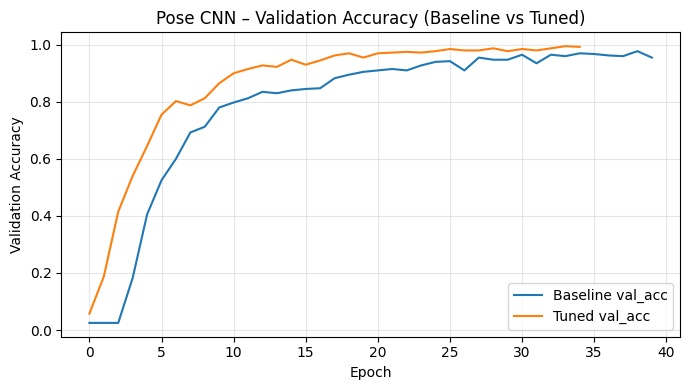

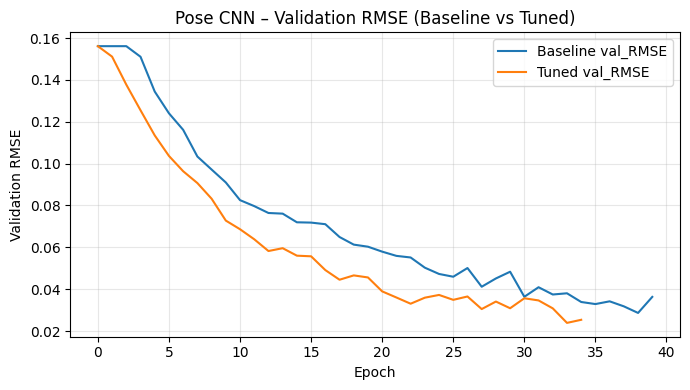

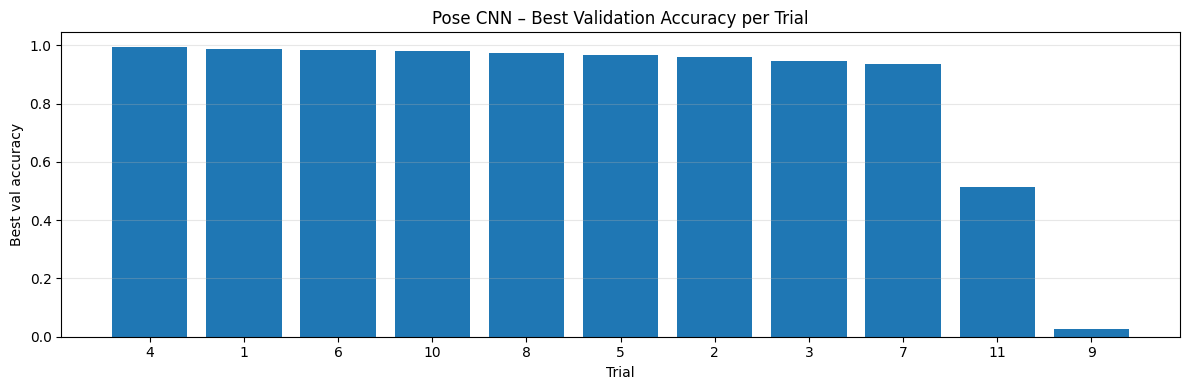

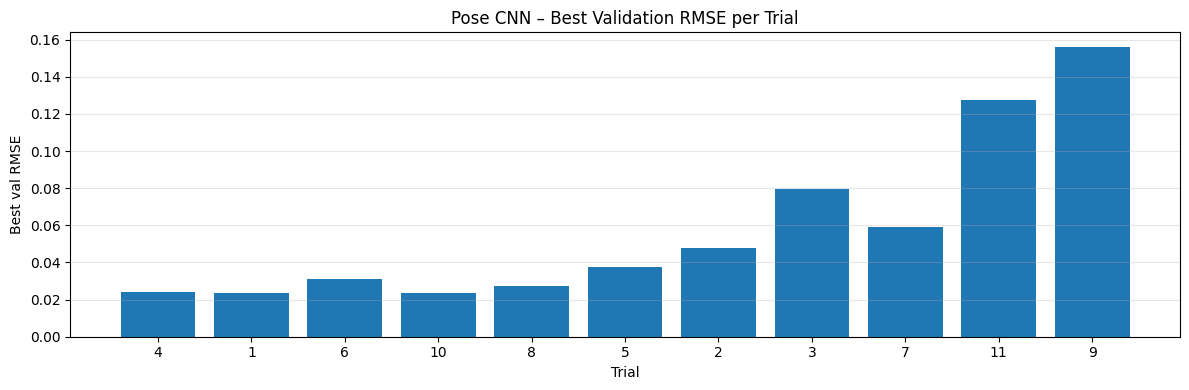


=== Summary: Baseline vs Tuned ===
Baseline best val accuracy: 0.9775
Tuned best val accuracy   : 0.9950
Baseline best val RMSE    : 0.0287
Tuned best val RMSE       : 0.0239
Baseline best val loss    : 0.0849
Tuned best val loss       : 0.8052


In [ ]:
# Pose CNN – Baseline and Hyperparameter Tuning

SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Image dimensions
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH  = IMG_SIZE


def rmse_probs(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


# Build Pose CNN with configurable hyperparameters

def build_cnn_pose(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=num_classes,
    dropout_rate=0.5,
    dense_units=256,
    l2_weight=0.0,
    use_batchnorm=False,
):
    inputs = keras.Input(shape=input_shape, name="input_image")

    # Data augmentation applied only during training
    x = data_augmentation(inputs, training=True)

    # Identity rescaling
    x = layers.Rescaling(1.0)(x)

    # Helper: convolution + optional batch norm + max pooling
    def conv_block(x, filters):
        x = layers.Conv2D(
            filters, 3, padding="same", activation="relu",
            kernel_regularizer=regularizers.l2(l2_weight) if l2_weight > 0 else None
        )(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        return x

    # Five convolutional blocks
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    # Fully connected classification head
    x = layers.Flatten()(x)
    x = layers.Dense(
        dense_units, activation="relu",
        kernel_regularizer=regularizers.l2(l2_weight) if l2_weight > 0 else None
    )(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="pose_logits")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cnn_pose")
    return model



# Training helper function

def train_one_model(
    model,
    lr,
    label_smoothing=0.0,
    epochs=40,
    ckpt_path="cnn_pose_tmp_best.keras",
):
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=False,
            label_smoothing=label_smoothing
        ),
        metrics=["accuracy", rmse_probs],
    )

    # Save best model by validation accuracy
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=0,
    )

    # Early stopping based on validation loss
    earlystop_cb = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=10,
        restore_best_weights=True,
        verbose=1,
    )

    # Train model
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=[checkpoint_cb, earlystop_cb],
        verbose=1,
    )

    # Load best checkpoint weights
    if os.path.exists(ckpt_path):
        model.load_weights(ckpt_path)

    # Extract best validation metrics
    best_val_acc  = float(np.max(history.history["val_accuracy"]))
    best_val_loss = float(np.min(history.history["val_loss"]))
    best_val_rmse = float(np.min(history.history["val_rmse_probs"]))

    return history, best_val_acc, best_val_loss, best_val_rmse



# Train baseline configuration once

tf.keras.backend.clear_session()

baseline_model = build_cnn_pose(
    dropout_rate=0.5,
    dense_units=256,
    l2_weight=0.0,
    use_batchnorm=False,
)

print("\n=== Training BASELINE CNN ===")
hist_base, base_best_acc, base_best_loss, base_best_rmse = train_one_model(
    baseline_model,
    lr=1e-3,
    label_smoothing=0.0,
    epochs=40,
    ckpt_path="cnn_pose_baseline_best.keras",
)

print("\nBaseline best val accuracy:", base_best_acc)
print("Baseline best val loss    :", base_best_loss)
print("Baseline best val RMSE    :", base_best_rmse)



# Hyperparameter tuning via random search

search_space = {
    "lr":              [3e-4, 5e-4, 1e-3],
    "dropout":         [0.3, 0.4, 0.5],
    "dense_units":     [128, 256, 512],
    "l2_weight":       [0.0, 1e-5, 1e-4],
    "label_smoothing": [0.0, 0.05, 0.1],
    "batchnorm":       [False, True],
}

N_TRIALS = 12
EPOCHS_PER_TRIAL = 35

results = []
histories = {}

print("\n=== Hyperparameter Tuning (random search) ===")

# Randomly sample configurations
trial_configs = []
for _ in range(N_TRIALS):
    cfg = {
        "lr": random.choice(search_space["lr"]),
        "dropout": random.choice(search_space["dropout"]),
        "dense_units": random.choice(search_space["dense_units"]),
        "l2_weight": random.choice(search_space["l2_weight"]),
        "label_smoothing": random.choice(search_space["label_smoothing"]),
        "batchnorm": random.choice(search_space["batchnorm"]),
    }
    trial_configs.append(cfg)

# Remove duplicate configurations
unique = []
seen = set()
for c in trial_configs:
    key = tuple(sorted(c.items()))
    if key not in seen:
        unique.append(c)
        seen.add(key)
trial_configs = unique

# Run tuning experiments
for i, cfg in enumerate(trial_configs, start=1):
    tf.keras.backend.clear_session()

    print(f"\n--- Trial {i}/{len(trial_configs)} ---")
    print(cfg)

    model = build_cnn_pose(
        dropout_rate=cfg["dropout"],
        dense_units=cfg["dense_units"],
        l2_weight=cfg["l2_weight"],
        use_batchnorm=cfg["batchnorm"],
    )

    ckpt = f"cnn_pose_tuned_trial{i}.keras"

    hist, best_acc, best_loss, best_rmse = train_one_model(
        model,
        lr=cfg["lr"],
        label_smoothing=cfg["label_smoothing"],
        epochs=EPOCHS_PER_TRIAL,
        ckpt_path=ckpt,
    )

    results.append({
        "trial": i,
        **cfg,
        "best_val_accuracy": best_acc,
        "best_val_loss": best_loss,
        "best_val_rmse": best_rmse,
        "ckpt_path": ckpt,
    })
    histories[i] = hist

results_df = pd.DataFrame(results)

# Rank trials by validation accuracy, then validation loss
results_df = results_df.sort_values(
    by=["best_val_accuracy", "best_val_loss"],
    ascending=[False, True]
).reset_index(drop=True)

print("\n=== Tuning Results (sorted) ===")
print(results_df[[
    "trial","lr","dropout","dense_units","l2_weight",
    "label_smoothing","batchnorm",
    "best_val_accuracy","best_val_loss","best_val_rmse"
]].to_string(index=False))

best = results_df.iloc[0].to_dict()
best_trial = int(best["trial"])
print("\nBEST TRIAL:")
print(best)



# Load best tuned model for comparison plots

tf.keras.backend.clear_session()

best_model = build_cnn_pose(
    dropout_rate=float(best["dropout"]),
    dense_units=int(best["dense_units"]),
    l2_weight=float(best["l2_weight"]),
    use_batchnorm=bool(best["batchnorm"]),
)

best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=float(best["lr"])),
    loss=keras.losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=float(best["label_smoothing"])
    ),
    metrics=["accuracy", rmse_probs],
)

best_model.load_weights(best["ckpt_path"])


# Training curves: baseline vs tuned

hist_best = histories[best_trial]

# Validation accuracy
plt.figure(figsize=(7, 4))
plt.plot(hist_base.history["val_accuracy"], label="Baseline val_acc")
plt.plot(hist_best.history["val_accuracy"], label="Tuned val_acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Pose CNN – Validation Accuracy (Baseline vs Tuned)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Validation RMSE
plt.figure(figsize=(7, 4))
plt.plot(hist_base.history["val_rmse_probs"], label="Baseline val_RMSE")
plt.plot(hist_best.history["val_rmse_probs"], label="Tuned val_RMSE")
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Pose CNN – Validation RMSE (Baseline vs Tuned)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Per-trial performance summary plots

plt.figure(figsize=(12, 4))
plt.bar(results_df["trial"].astype(str), results_df["best_val_accuracy"])
plt.xlabel("Trial")
plt.ylabel("Best val accuracy")
plt.title("Pose CNN – Best Validation Accuracy per Trial")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(results_df["trial"].astype(str), results_df["best_val_rmse"])
plt.xlabel("Trial")
plt.ylabel("Best val RMSE")
plt.title("Pose CNN – Best Validation RMSE per Trial")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# Final comparison summary
print("\n=== Summary: Baseline vs Tuned ===")
print(f"Baseline best val accuracy: {base_best_acc:.4f}")
print(f"Tuned best val accuracy   : {best['best_val_accuracy']:.4f}")

print(f"Baseline best val RMSE    : {base_best_rmse:.4f}")
print(f"Tuned best val RMSE       : {best['best_val_rmse']:.4f}")

print(f"Baseline best val loss    : {base_best_loss:.4f}")
print(f"Tuned best val loss       : {best['best_val_loss']:.4f}")
